In [227]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#sklearn
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV
from sklearn.inspection import permutation_importance

from sklearn.neighbors import KNeighborsClassifier

#json
import json

<h3>Functions</h3>

In [228]:
def plot_grid_search_results(grid_results, grid_best_params, grid_best_score):
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (12,18)) #figsize = (13,30)
    
    ax1.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_f1'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_f1'],
                 ecolor = 'orange')
    ax1.set_xlabel('n_neigbors')
    ax1.set_ylabel('f1')
    ax1.set_title('Classification F1')
    
    ax2.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_recall'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_recall'],
                 ecolor = 'orange')
    ax2.set_xlabel('n_neigbors') 
    ax2.set_ylabel('recall')
    ax2.set_title('Classification Recall')
    
    ax3.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_roc_auc'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_roc_auc'],
                 ecolor = 'orange')
    ax3.plot([grid_best_params['n_neighbors']], [grid_best_score], 
              marker='.', 
              markeredgewidth=3,
              c='r')
    ax3.annotate('best k', xy = (grid_best_params['n_neighbors'], grid_best_score),
                 xytext = (grid_best_params['n_neighbors'] + 1, grid_best_score + 0.02),
                 arrowprops=dict(facecolor='black', shrink=0.01))
    ax3.set_xlabel('n_neigbors') 
    ax3.set_ylabel('roc auc')
    ax3.set_title('Classification Roc Auc')

    fig.tight_layout()
    plt.show()

In [229]:
def results_permutation_importance(res, attr):
    
    # get importance
    importance = res.importances_mean
    
    # summarize feature importance
    feature_importances = []
    for col, imp in zip(attr, importance):
        feature_importances.append((col, imp))
  
    sorted_feature_importances = sorted(feature_importances, key=lambda tup:(-tup[1], tup[0]))
    
    return sorted_feature_importances

In [230]:
def plot_permutation_importance(res, attr, tit):
    
    fig, ax = plt.subplots(figsize = (12,8)) 
    
    feature_names = np.r_[attr]
    
    importance = res.importances_mean
    sorted_idx = res.importances_mean.argsort()
    
    y_ticks = np.arange(0, len(feature_names))
    ax.barh(y_ticks, importance[sorted_idx], height=0.7, color = "#CC6600")
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_title(tit)
    
    fig.tight_layout()
    plt.show()

In [231]:
def draw_confusion_matrix(Clf, X, y):
    
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(Clf, X, y,
                                 cmap='OrRd',
                                 normalize=normalize)
        disp.ax_.set_title(title)
    
    plt.show()

In [232]:
def draw_roc_curve(Y_test, Y_pred, diz, k):
    
    fig, ax = plt.subplots() #figsize = (13,30)
    
    fpr, tpr, _ = roc_curve(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred, average = None)
    
    diz[k] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc": roc_auc}
    
    ax.plot(fpr, tpr, color = "#994D00", label='ROC curve (area = %0.2f)' % (roc_auc))
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate') 
    ax.set_title('Roc curve of the model')
    ax.tick_params(axis='both')
    ax.legend(loc="lower right", fontsize=14, frameon=False)
    
    fig.tight_layout()
    plt.show()

<h3>Onehot encoding</h3>

In [233]:
df = pd.read_csv("Numerical_NON_NORMALIZED_Train_HR_Employee_Attrition.csv")

In [234]:
df

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,0,1,0,9,4,2,0,3,...,17,3,0,2,2,8,7,156.61,0.39,2
1,36,0,0,1,0,1,1,2,0,3,...,14,3,1,3,3,1,8,157.94,0.41,2
2,25,0,0,0,1,16,3,3,0,3,...,25,3,1,4,3,1,5,448.06,0.70,3
3,33,0,0,1,0,5,4,2,0,3,...,14,2,0,1,3,3,7,271.91,0.84,2
4,31,0,0,1,0,9,2,3,1,3,...,12,3,0,2,3,10,2,106.37,0.21,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,38,1,0,1,0,12,3,3,1,4,...,15,4,0,2,3,10,0,282.47,0.79,3
879,37,0,0,1,0,16,2,4,1,4,...,13,2,2,3,2,17,0,76.29,0.71,3
880,33,1,1,0,0,6,4,2,1,1,...,18,2,0,2,2,11,7,272.88,0.75,2
881,33,0,0,1,0,4,1,3,0,2,...,12,1,0,2,4,3,2,208.67,0.86,2


In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 36 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     883 non-null    int64  
 1   Attrition                               883 non-null    int64  
 2   BusinessTravel_Non-Travel               883 non-null    int64  
 3   BusinessTravel_Travel_Rarely            883 non-null    int64  
 4   BusinessTravel_Travel_Frequently        883 non-null    int64  
 5   DistanceFromHome                        883 non-null    int64  
 6   Education                               883 non-null    int64  
 7   EnvironmentSatisfaction                 883 non-null    int64  
 8   Gender                                  883 non-null    int64  
 9   JobInvolvement                          883 non-null    int64  
 10  JobLevel                                883 non-null    int64 

In [236]:
df.describe()

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
count,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,...,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000
mean,36.554926,0.173273,0.101925,0.733862,0.164213,9.201586,2.886750,2.684032,0.388448,2.750849,...,15.207248,2.716874,0.793884,2.665912,2.767837,6.326161,3.919592,234.245832,0.463918,2.322763
std,8.266129,0.378698,0.302721,0.442188,0.370679,8.241818,1.008285,1.092567,0.487674,0.729354,...,3.589332,1.078137,0.865362,1.187828,0.721713,4.523567,3.435392,130.196652,0.319880,0.535595
min,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,26.040000,0.000000,1.000000
25%,30.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,...,12.000000,2.000000,0.000000,2.000000,2.000000,3.000000,2.000000,130.630000,0.130000,2.000000
50%,35.000000,0.000000,0.000000,1.000000,0.000000,7.000000,3.000000,3.000000,0.000000,3.000000,...,14.000000,3.000000,1.000000,2.000000,3.000000,5.000000,3.000000,212.280000,0.530000,2.000000
75%,42.000000,0.000000,0.000000,1.000000,0.000000,14.000000,4.000000,4.000000,1.000000,3.000000,...,18.000000,4.000000,1.000000,3.000000,3.000000,9.000000,7.000000,309.905000,0.760000,3.000000
max,60.000000,1.000000,1.000000,1.000000,1.000000,29.000000,5.000000,4.000000,1.000000,4.000000,...,25.000000,4.000000,3.000000,6.000000,4.000000,20.000000,16.000000,590.980000,0.950000,4.000000


<h3>Discretization</h3>

Continuous features to discretize:
- <b>Age</b>
- <b>DistanceFromHome</b>
- <b>YearsAtCompany</b>
- <b>YearsInCurrentRole</b>
- <b>NumCompaniesWorked</b>
- <b>MonthlyIncome</b>
- <b>MonthlyHours</b>
- <b>PercentSalaryHike</b>

In [237]:
columns_to_discretize = ['Age','DistanceFromHome','YearsAtCompany','YearsInCurrentRole',
'NumCompaniesWorked','MonthlyIncome','MonthlyHours','PercentSalaryHike']

In [238]:
df.head()

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,0,1,0,9,4,2,0,3,...,17,3,0,2,2,8,7,156.61,0.39,2
1,36,0,0,1,0,1,1,2,0,3,...,14,3,1,3,3,1,8,157.94,0.41,2
2,25,0,0,0,1,16,3,3,0,3,...,25,3,1,4,3,1,5,448.06,0.70,3
3,33,0,0,1,0,5,4,2,0,3,...,14,2,0,1,3,3,7,271.91,0.84,2
4,31,0,0,1,0,9,2,3,1,3,...,12,3,0,2,3,10,2,106.37,0.21,3


In [239]:
for column in columns_to_discretize:
    if column in df:
        df[column] = pd.qcut(df[column], q=4, duplicates='drop', labels=False)

In [240]:
df.head()

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,3,0,0,1,0,2,4,2,0,3,...,2,3,0,2,2,2,2,1,0.39,2
1,2,0,0,1,0,0,1,2,0,3,...,1,3,1,3,3,0,3,1,0.41,2
2,0,0,0,0,1,3,3,3,0,3,...,3,3,1,4,3,0,2,3,0.70,3
3,1,0,0,1,0,1,4,2,0,3,...,1,2,0,1,3,0,2,2,0.84,2
4,1,0,0,1,0,2,2,3,1,3,...,0,3,0,2,3,3,0,0,0.21,3


<h3>Divide into features and target</h3>

In [241]:
attributes = [col for col in df.columns if col != 'Attrition']

X = df[attributes].values
y = df['Attrition']

<h3>Stratified Holdout combined with Stratified K-fold Cross Validation</h3>

In [242]:
s = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
for a, b in s:
    k = "%s-%s" % (int(a*100), int(b*100))
    print(k)
    print()

60-40

70-30

80-20



In [243]:
scaler_dict = dict()

<h4>MinMaxScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6018067592559017
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


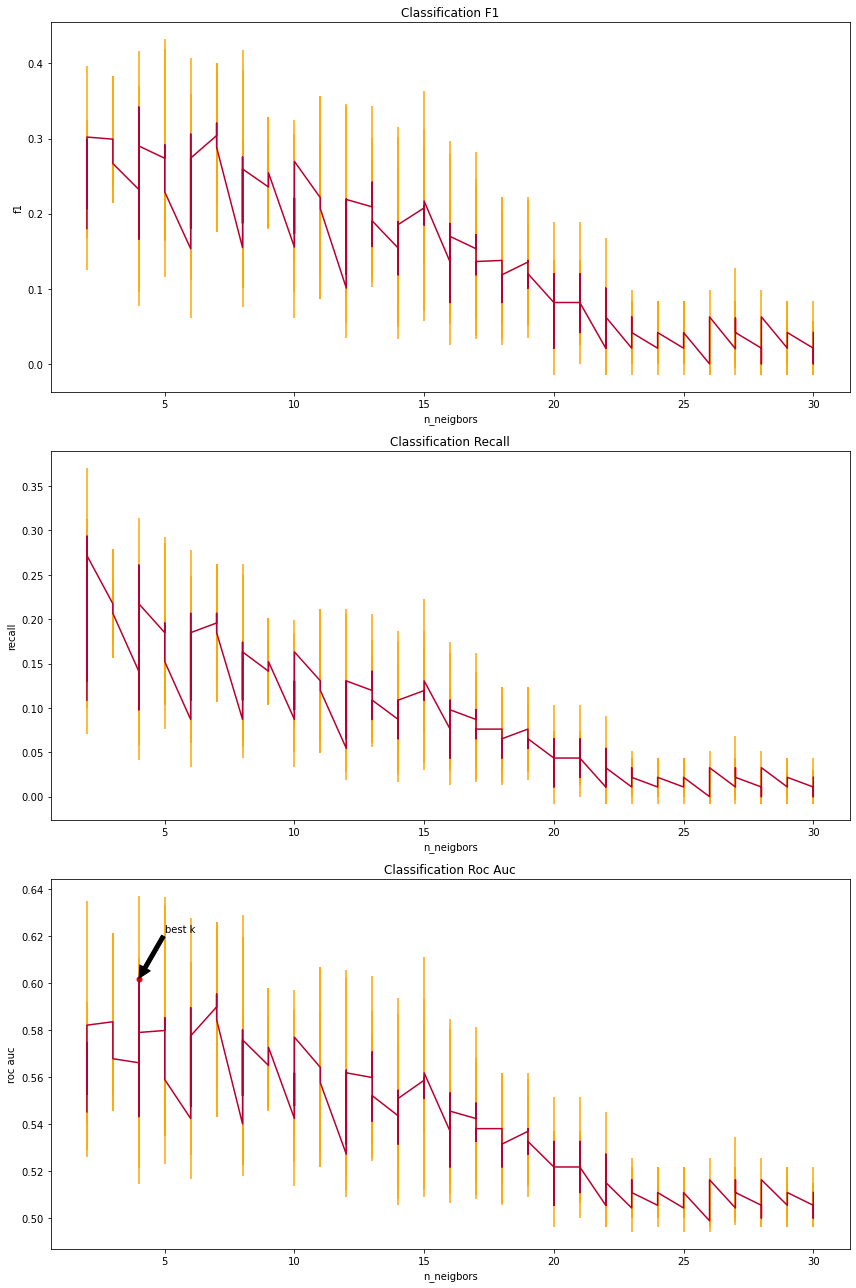



Permutation importances of the training set

Age                                                0.000000
BusinessTravel_Non-Travel                          0.000000
BusinessTravel_Travel_Frequently                   0.000000
BusinessTravel_Travel_Rarely                       0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Healthcare_Representative                  0.000000
JobRole_Human_Resources                            0.000000
JobRole_Laboratory_Technician                      0.000000
JobRole_Manager_Human_Resources                    0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manager_Sales                              0.

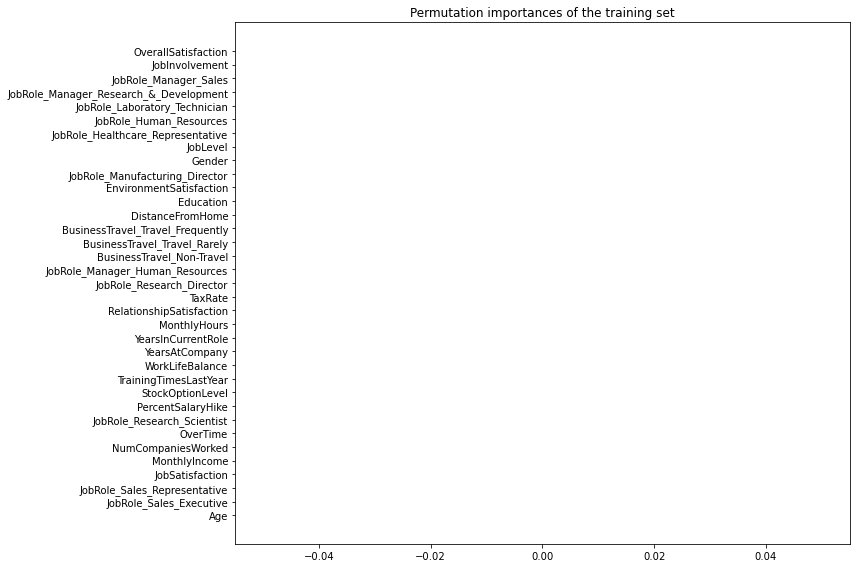



Predictions

Permutation importances of the test set

OverTime                                           0.045893
YearsInCurrentRole                                 0.029662
JobLevel                                           0.023107
MonthlyIncome                                      0.021258
JobInvolvement                                     0.017795
StockOptionLevel                                   0.016922
BusinessTravel_Travel_Frequently                   0.014880
Age                                                0.014729
BusinessTravel_Travel_Rarely                       0.012116
RelationshipSatisfaction                           0.011817
JobRole_Laboratory_Technician                      0.011036
JobRole_Healthcare_Representative                  0.007567
OverallSatisfaction                                0.007083
NumCompaniesWorked                                 0.007033
JobRole_Manufacturing_Director                     0.003841
JobRole_Research_Scientist                  

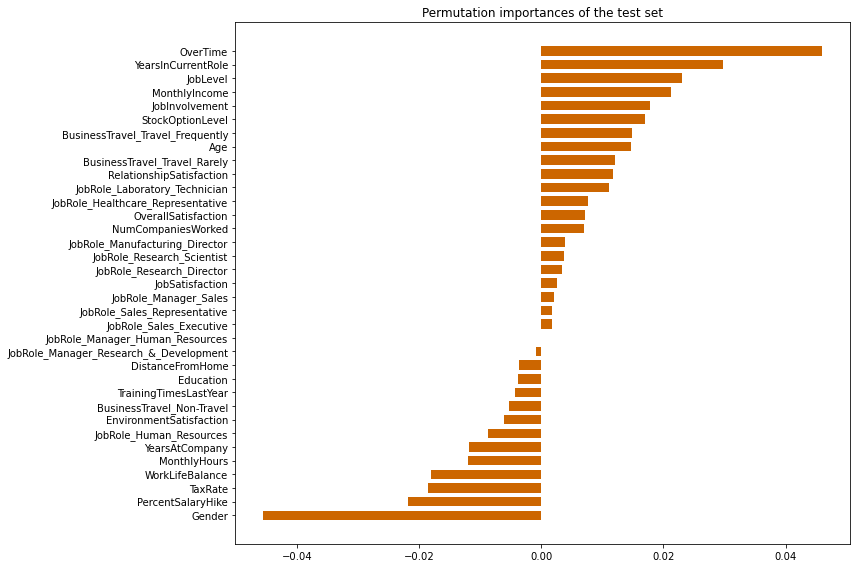



Confusion matrix


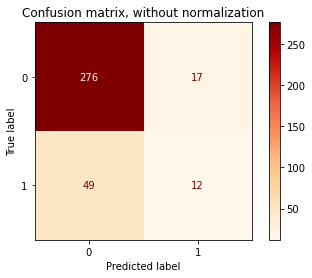

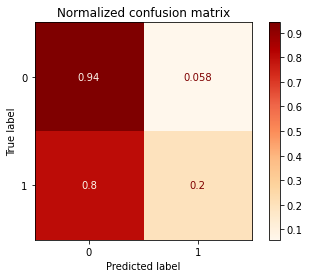


Classification report
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       293
           1       0.41      0.20      0.27        61

    accuracy                           0.81       354
   macro avg       0.63      0.57      0.58       354
weighted avg       0.77      0.81      0.79       354


Metrics

Accuracy 0.8135593220338984
F1-score [0.89320388 0.26666667]
Precision [0.84923077 0.4137931 ]
Recall [0.94197952 0.19672131]
Roc_auc 0.5693504168298551


Roc curve



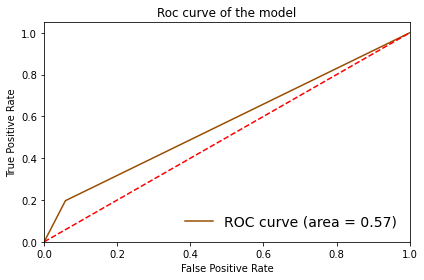


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5900727471916571
Best parameters: {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


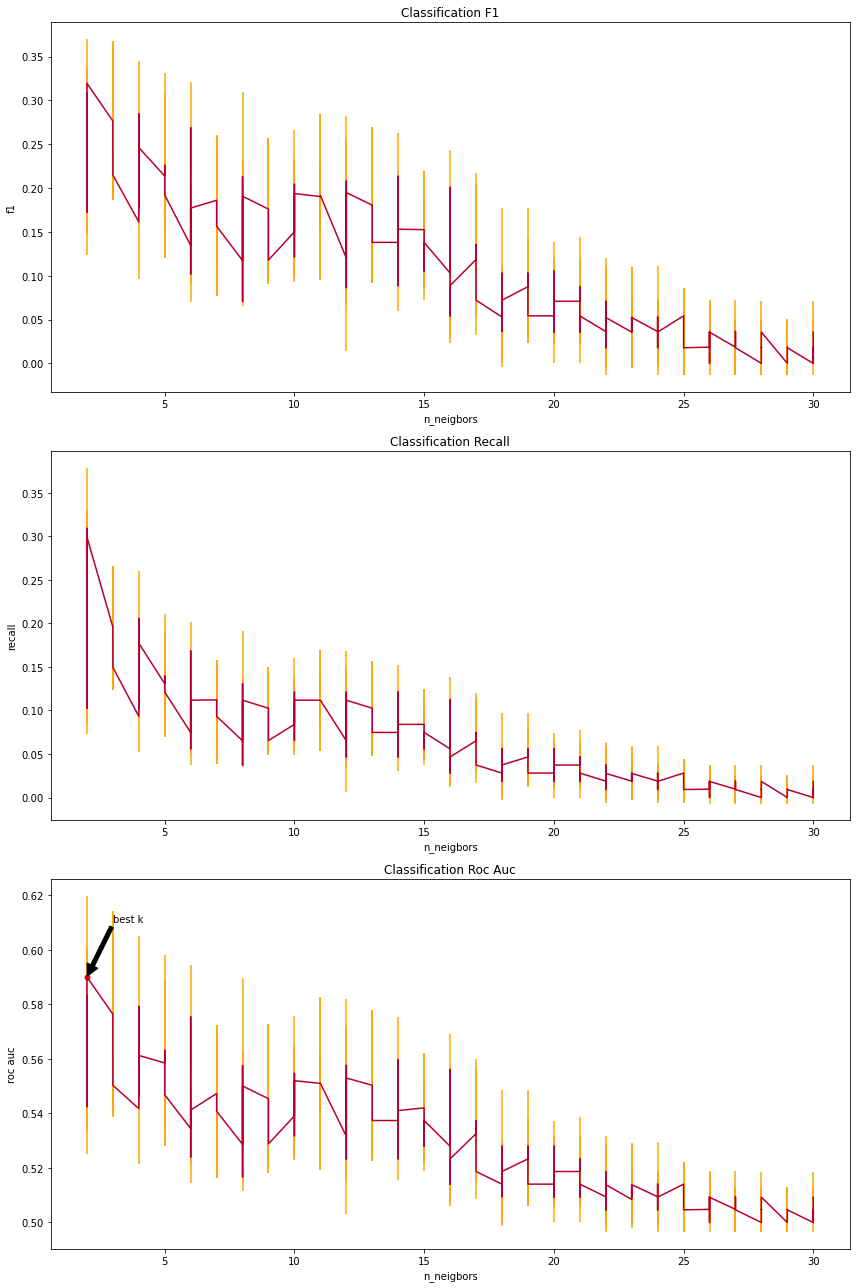



Permutation importances of the training set

Gender                                             0.000007
YearsInCurrentRole                                 0.000007
Age                                                0.000000
BusinessTravel_Non-Travel                          0.000000
BusinessTravel_Travel_Frequently                   0.000000
BusinessTravel_Travel_Rarely                       0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Healthcare_Representative                  0.000000
JobRole_Human_Resources                            0.000000
JobRole_Laboratory_Technician                      0.000000
JobRole_Manager_Human_Resources                    0.000000
JobRole_Manager_Research_&_Development             0.

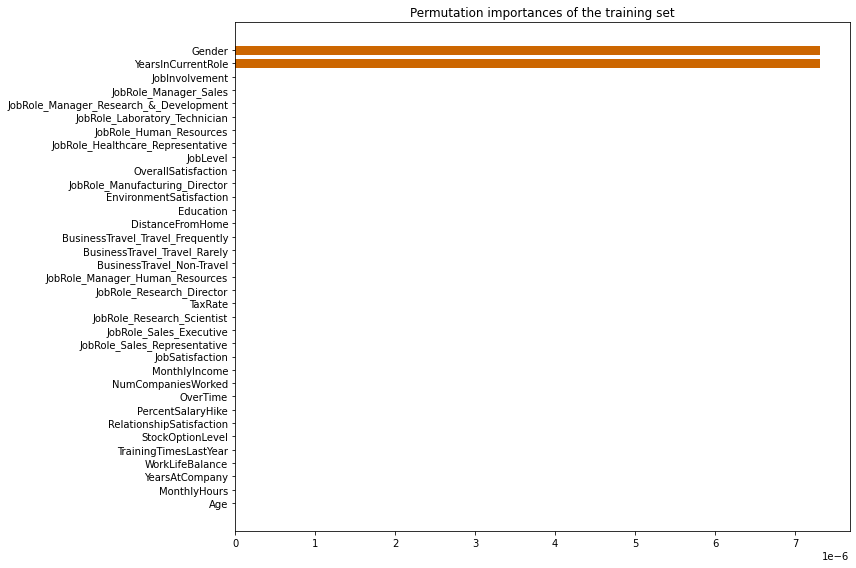



Predictions

Permutation importances of the test set

OverTime                                           0.037934
BusinessTravel_Travel_Frequently                   0.025670
JobRole_Sales_Representative                       0.016989
BusinessTravel_Travel_Rarely                       0.015123
JobLevel                                           0.008299
Education                                          0.006080
JobRole_Manufacturing_Director                     0.005127
JobRole_Manager_Sales                              0.003355
YearsInCurrentRole                                 0.003335
TrainingTimesLastYear                              0.000591
JobSatisfaction                                    0.000561
JobRole_Manager_Human_Resources                    -0.000020
JobRole_Manager_Research_&_Development             -0.000164
JobRole_Research_Director                          -0.001052
JobRole_Research_Scientist                         -0.002224
JobRole_Healthcare_Representative       

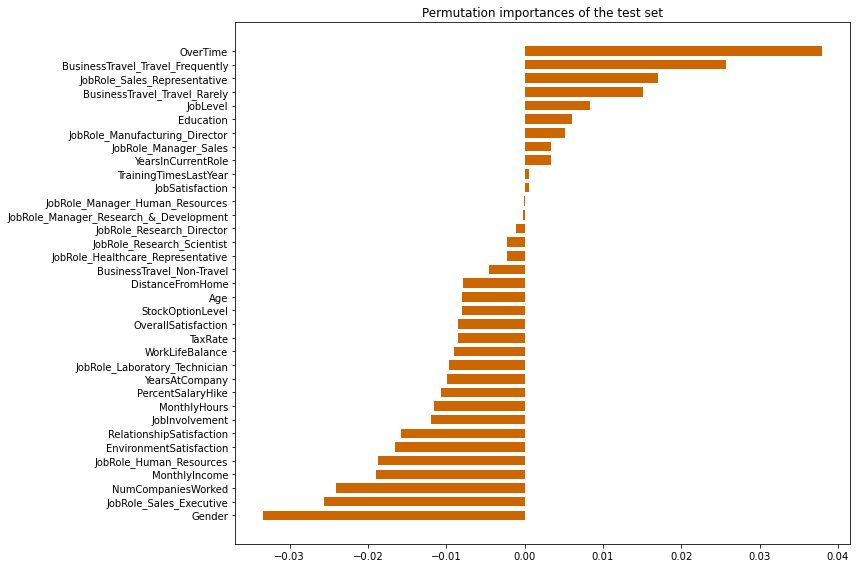



Confusion matrix


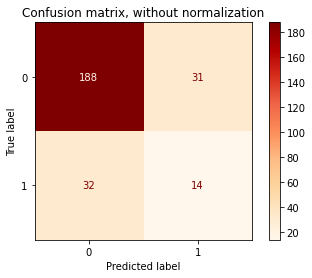

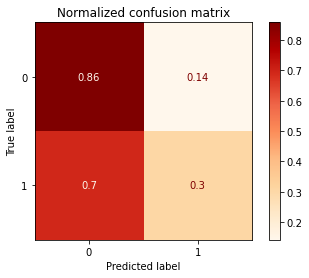


Classification report
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       219
           1       0.31      0.30      0.31        46

    accuracy                           0.76       265
   macro avg       0.58      0.58      0.58       265
weighted avg       0.76      0.76      0.76       265


Metrics

Accuracy 0.7622641509433963
F1-score [0.85649203 0.30769231]
Precision [0.85454545 0.31111111]
Recall [0.85844749 0.30434783]
Roc_auc 0.5813976573357157


Roc curve



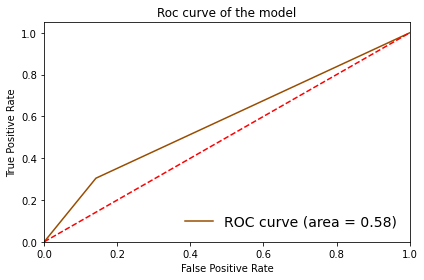


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6210192959198704
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


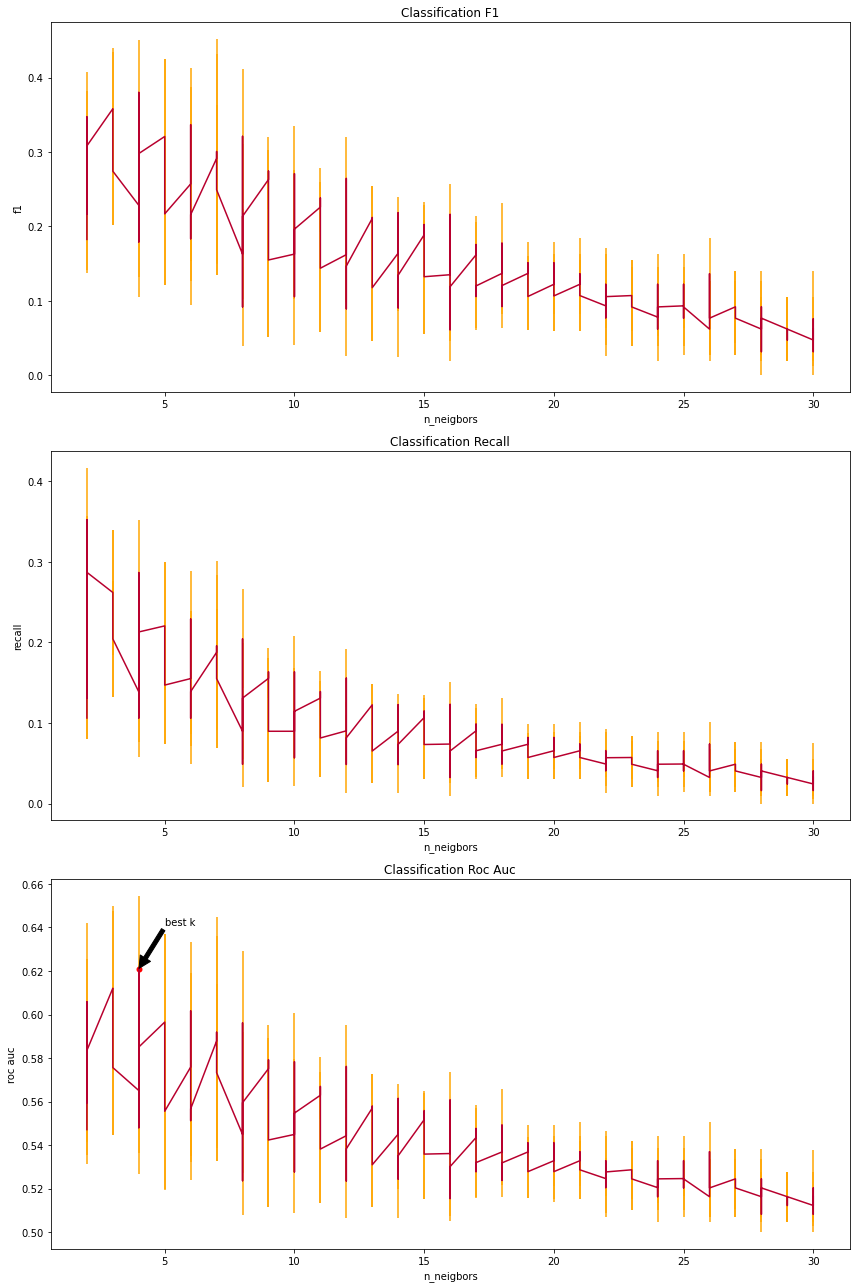



Permutation importances of the training set

Age                                                0.000000
BusinessTravel_Non-Travel                          0.000000
BusinessTravel_Travel_Frequently                   0.000000
BusinessTravel_Travel_Rarely                       0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Healthcare_Representative                  0.000000
JobRole_Human_Resources                            0.000000
JobRole_Laboratory_Technician                      0.000000
JobRole_Manager_Human_Resources                    0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manager_Sales                              0.

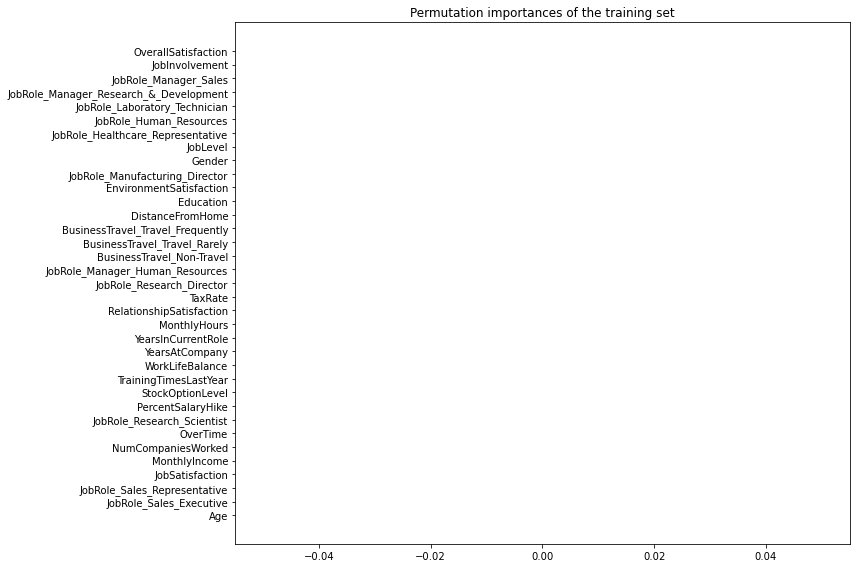



Predictions

Permutation importances of the test set

OverTime                                           0.038787
JobRole_Research_Scientist                         0.038124
YearsInCurrentRole                                 0.021730
JobLevel                                           0.020228
JobSatisfaction                                    0.020073
OverallSatisfaction                                0.017123
RelationshipSatisfaction                           0.014980
JobRole_Manufacturing_Director                     0.014284
JobRole_Laboratory_Technician                      0.012649
BusinessTravel_Travel_Rarely                       0.008937
MonthlyIncome                                      0.008551
Age                                                0.007114
BusinessTravel_Travel_Frequently                   0.006352
PercentSalaryHike                                  0.005071
JobRole_Healthcare_Representative                  0.005049
DistanceFromHome                            

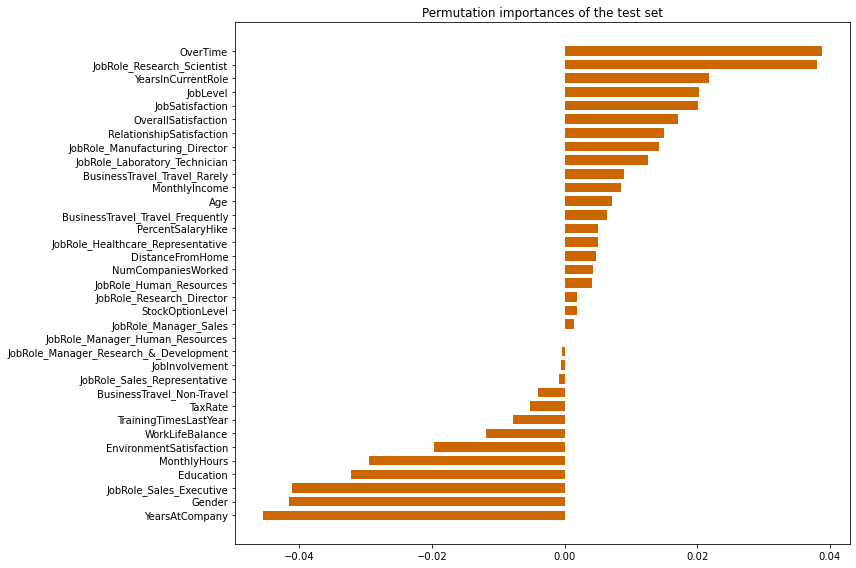



Confusion matrix


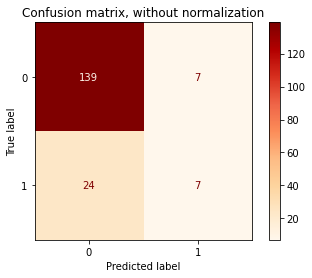

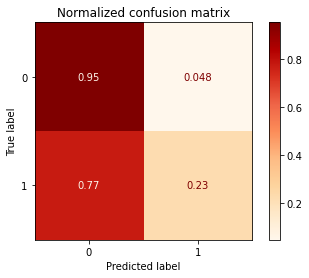


Classification report
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       146
           1       0.50      0.23      0.31        31

    accuracy                           0.82       177
   macro avg       0.68      0.59      0.61       177
weighted avg       0.79      0.82      0.80       177


Metrics

Accuracy 0.8248587570621468
F1-score [0.89967638 0.31111111]
Precision [0.85276074 0.5       ]
Recall [0.95205479 0.22580645]
Roc_auc 0.5889306230667256


Roc curve



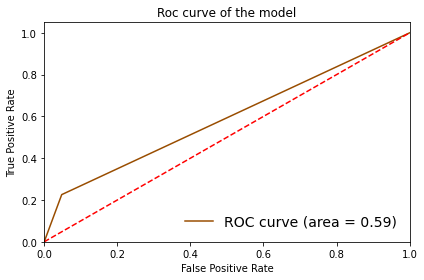


-------------------------------------------------------------------------------------------------------------



In [244]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
min_max_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MinMaxScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, min_max_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = min_max_dict

In [245]:
scaler_dict

{'MinMaxScaler': {'60-40': {'fpr': [0.0, 0.05802047781569966, 1.0],
   'tpr': [0.0, 0.19672131147540983, 1.0],
   'roc': 0.5693504168298551},
  '70-30': {'fpr': [0.0, 0.1415525114155251, 1.0],
   'tpr': [0.0, 0.30434782608695654, 1.0],
   'roc': 0.5813976573357157},
  '80-20': {'fpr': [0.0, 0.04794520547945205, 1.0],
   'tpr': [0.0, 0.22580645161290322, 1.0],
   'roc': 0.5889306230667256}}}

In [91]:
s = str(scaler).replace("()", "")
print(s)

MinMaxScaler


<h4>MaxAbsScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.5975269246110889
Best parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=7, p=1, weights='distance')

Best k ('n_neighbors'): 7

Plots of the metrics used by the grid search


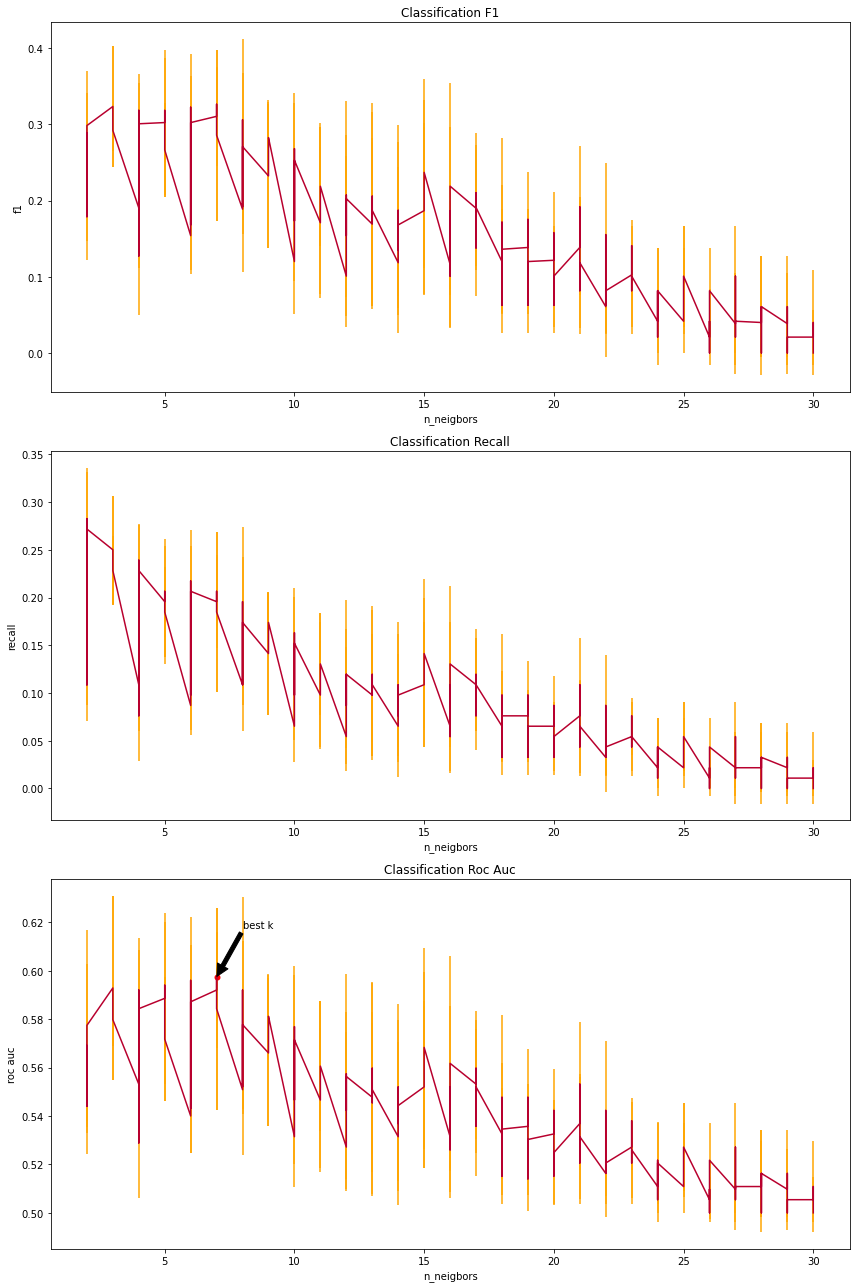



Permutation importances of the training set

OverTime                                           0.000478
Gender                                             0.000124
MonthlyHours                                       0.000037
YearsAtCompany                                     0.000020
JobRole_Research_Scientist                         0.000015
JobRole_Laboratory_Technician                      0.000002
Age                                                0.000000
BusinessTravel_Non-Travel                          0.000000
BusinessTravel_Travel_Frequently                   0.000000
BusinessTravel_Travel_Rarely                       0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Healthcare_Representative                  0.

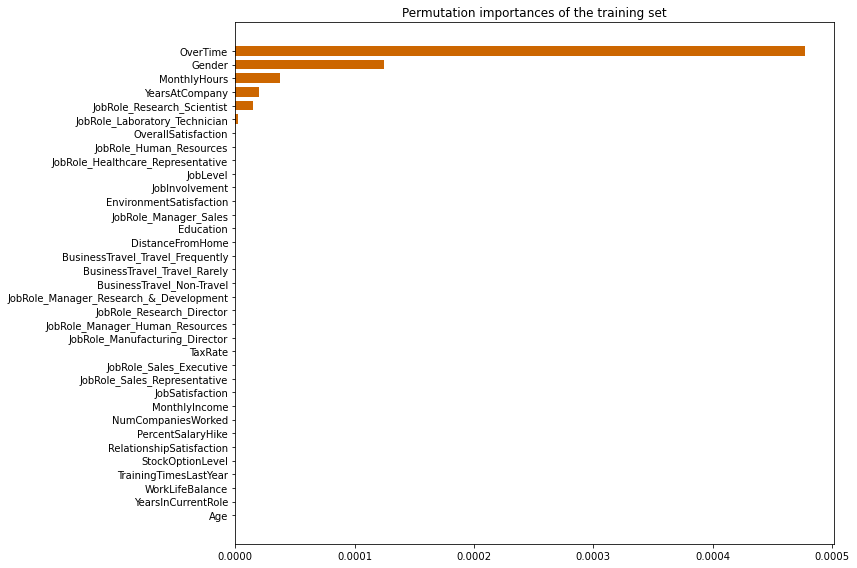



Predictions

Permutation importances of the test set

OverTime                                           0.066181
YearsInCurrentRole                                 0.043373
StockOptionLevel                                   0.039056
Age                                                0.028507
JobRole_Research_Scientist                         0.024702
JobRole_Sales_Executive                            0.021832
BusinessTravel_Travel_Rarely                       0.021630
MonthlyIncome                                      0.019406
BusinessTravel_Travel_Frequently                   0.018405
JobRole_Laboratory_Technician                      0.017037
JobRole_Manufacturing_Director                     0.016287
OverallSatisfaction                                0.015386
JobInvolvement                                     0.013884
RelationshipSatisfaction                           0.013389
YearsAtCompany                                     0.010337
JobLevel                                    

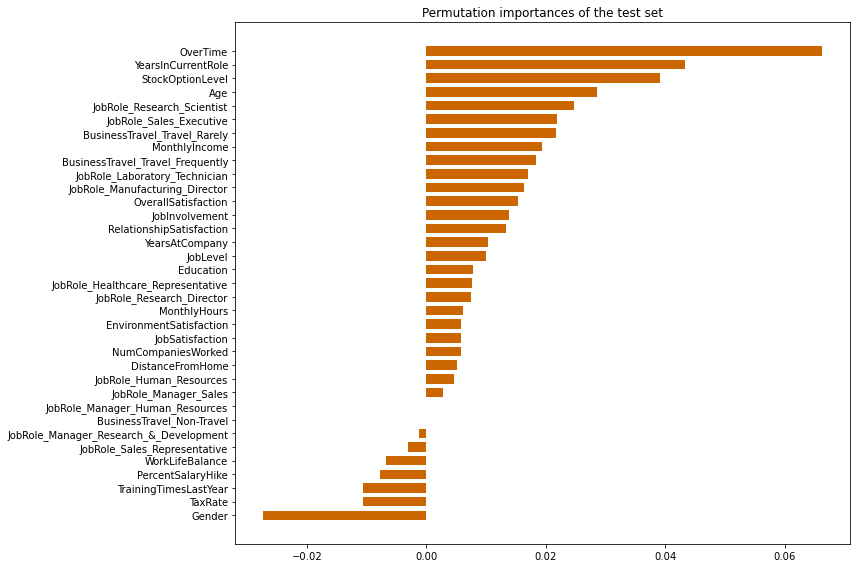



Confusion matrix


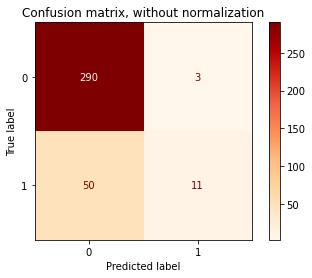

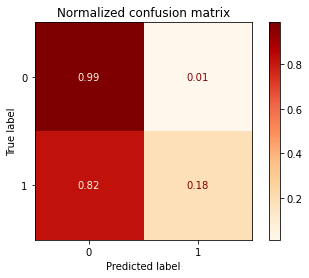


Classification report
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       293
           1       0.79      0.18      0.29        61

    accuracy                           0.85       354
   macro avg       0.82      0.59      0.60       354
weighted avg       0.84      0.85      0.81       354


Metrics

Accuracy 0.8502824858757062
F1-score [0.91627172 0.29333333]
Precision [0.85294118 0.78571429]
Recall [0.98976109 0.18032787]
Roc_auc 0.5850444805013149


Roc curve



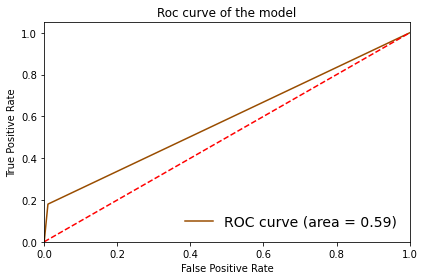


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5911942923200305
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


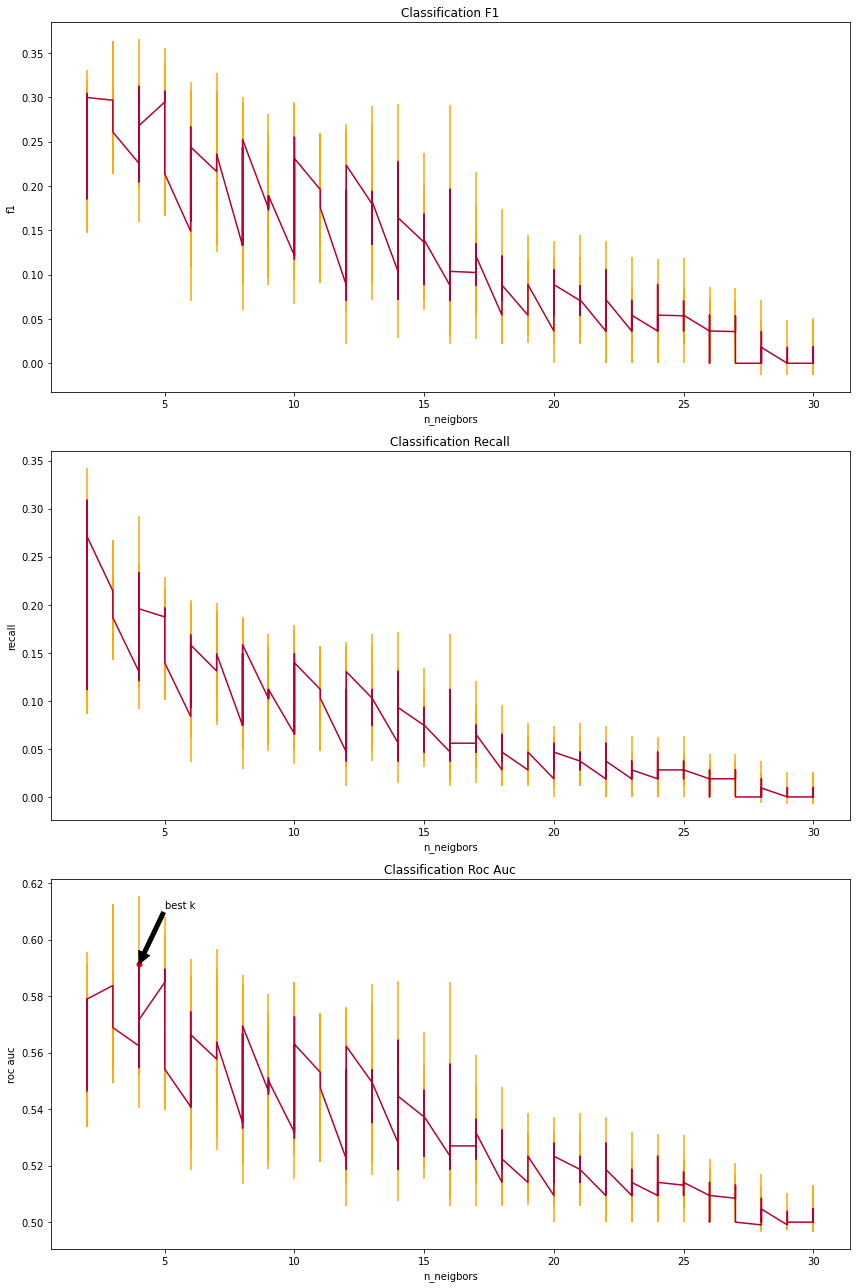



Permutation importances of the training set

Age                                                0.000000
BusinessTravel_Non-Travel                          0.000000
BusinessTravel_Travel_Frequently                   0.000000
BusinessTravel_Travel_Rarely                       0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Healthcare_Representative                  0.000000
JobRole_Human_Resources                            0.000000
JobRole_Laboratory_Technician                      0.000000
JobRole_Manager_Human_Resources                    0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manager_Sales                              0.

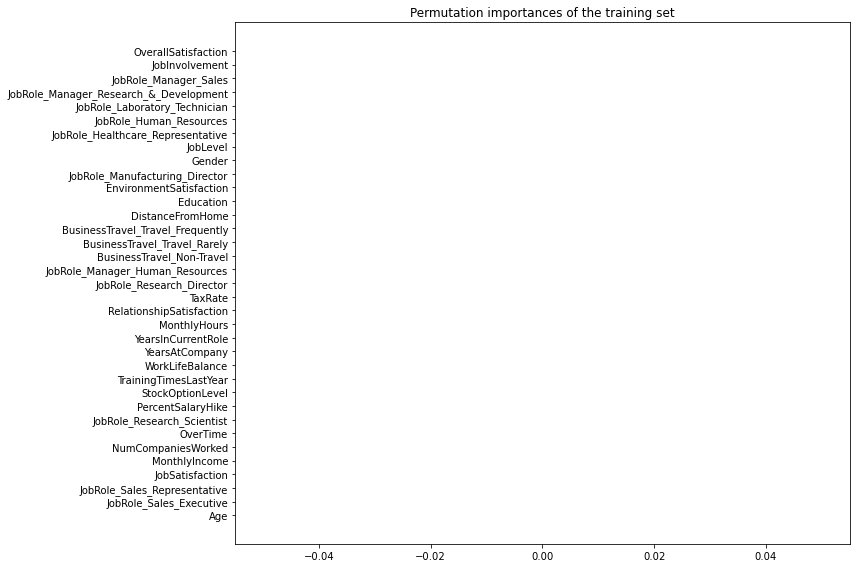



Predictions

Permutation importances of the test set

BusinessTravel_Travel_Rarely                       0.034807
YearsInCurrentRole                                 0.024662
BusinessTravel_Travel_Frequently                   0.024166
OverTime                                           0.019937
JobRole_Manufacturing_Director                     0.015639
JobLevel                                           0.011728
Age                                                0.009936
JobRole_Healthcare_Representative                  0.008899
JobSatisfaction                                    0.007658
RelationshipSatisfaction                           0.007390
OverallSatisfaction                                0.005162
JobInvolvement                                     0.004953
MonthlyIncome                                      0.004030
JobRole_Research_Director                          0.003891
EnvironmentSatisfaction                            0.002750
JobRole_Manager_Sales                       

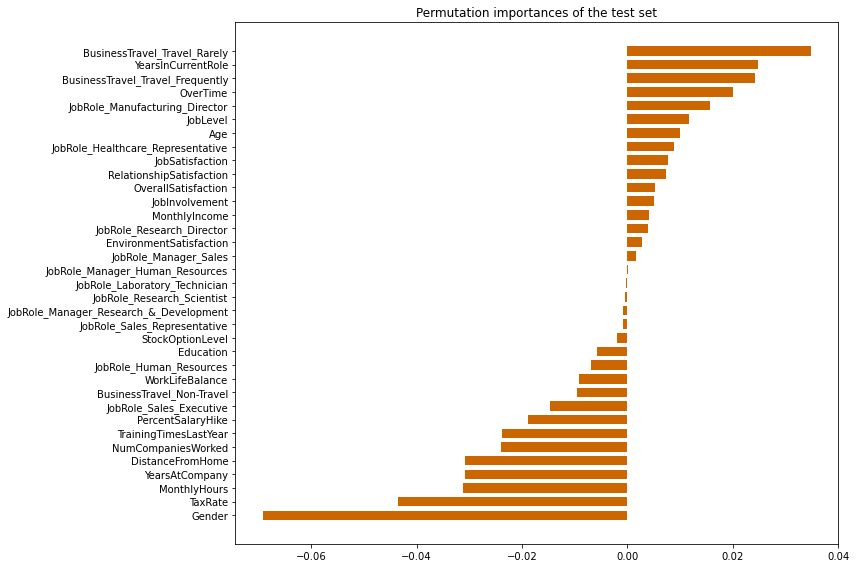



Confusion matrix


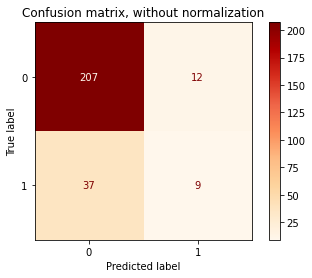

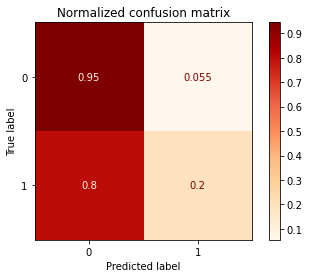


Classification report
              precision    recall  f1-score   support

           0       0.85      0.95      0.89       219
           1       0.43      0.20      0.27        46

    accuracy                           0.82       265
   macro avg       0.64      0.57      0.58       265
weighted avg       0.78      0.82      0.79       265


Metrics

Accuracy 0.8150943396226416
F1-score [0.89416847 0.26865672]
Precision [0.84836066 0.42857143]
Recall [0.94520548 0.19565217]
Roc_auc 0.5704288266825491


Roc curve



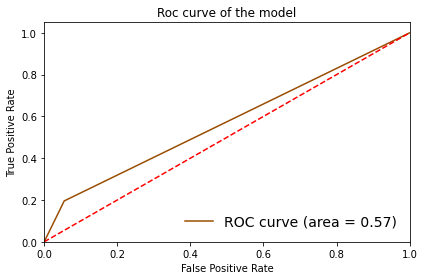


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6063337752246281
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=3, p=1)

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


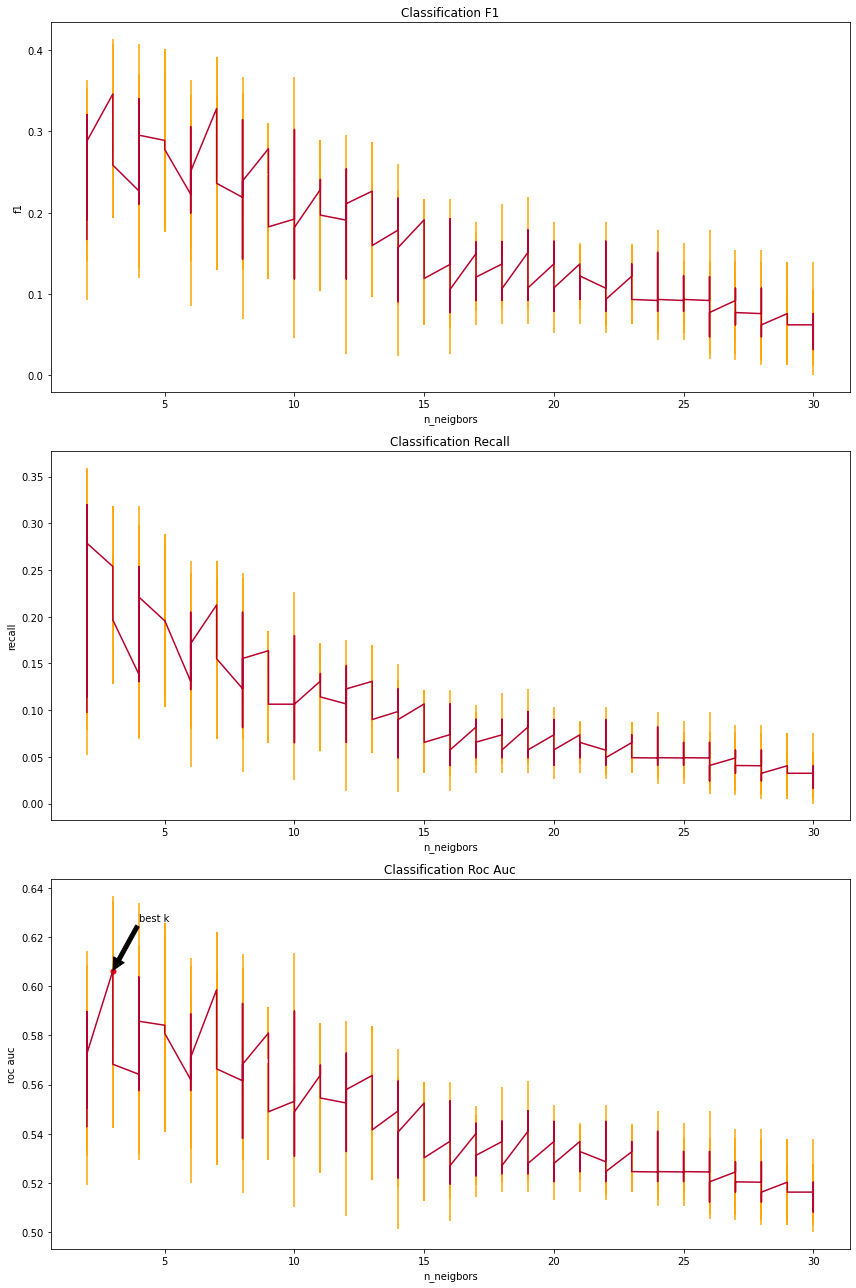



Permutation importances of the training set

OverTime                                           0.009753
StockOptionLevel                                   0.008215
JobLevel                                           0.004313
EnvironmentSatisfaction                            0.004018
Age                                                0.003899
JobRole_Manufacturing_Director                     0.003639
BusinessTravel_Non-Travel                          0.003400
NumCompaniesWorked                                 0.002840
YearsInCurrentRole                                 0.002730
JobRole_Human_Resources                            0.001964
RelationshipSatisfaction                           0.001844
JobRole_Healthcare_Representative                  0.001403
JobRole_Research_Director                          0.000874
OverallSatisfaction                                0.000463
JobRole_Sales_Representative                       0.000072
JobRole_Manager_Human_Resources                    0.

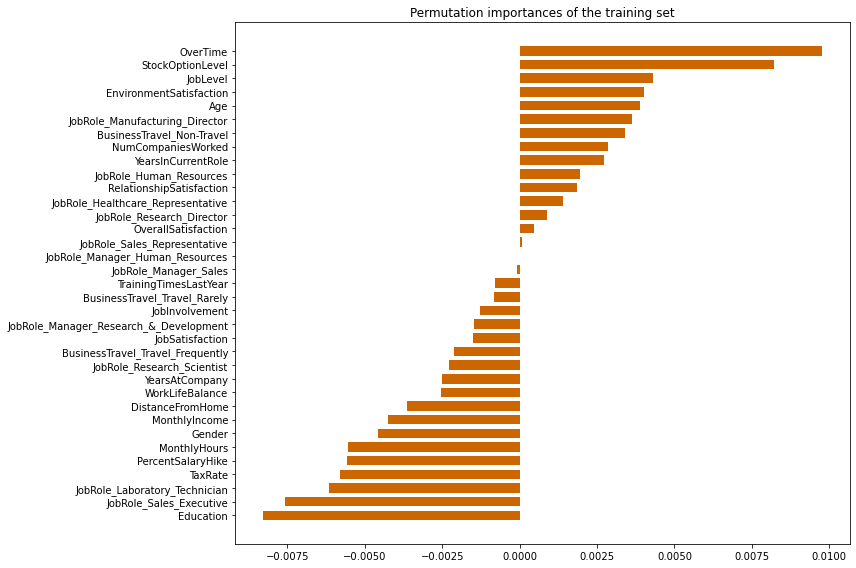



Predictions

Permutation importances of the test set

JobSatisfaction                                    0.055568
OverTime                                           0.052165
YearsInCurrentRole                                 0.048851
JobRole_Research_Scientist                         0.035583
JobInvolvement                                     0.035053
JobRole_Manufacturing_Director                     0.030115
Age                                                0.029065
BusinessTravel_Travel_Frequently                   0.024867
RelationshipSatisfaction                           0.024801
BusinessTravel_Travel_Rarely                       0.020592
DistanceFromHome                                   0.019653
JobLevel                                           0.018427
JobRole_Sales_Representative                       0.017565
PercentSalaryHike                                  0.015776
Education                                          0.013776
WorkLifeBalance                             

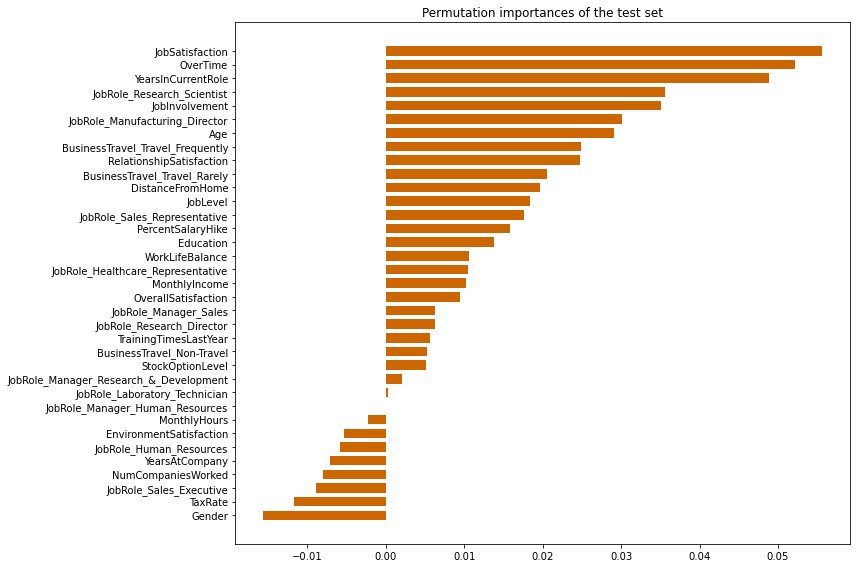



Confusion matrix


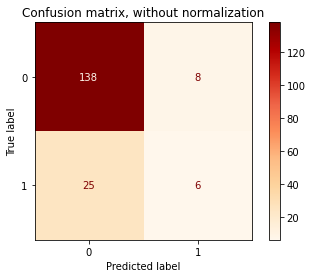

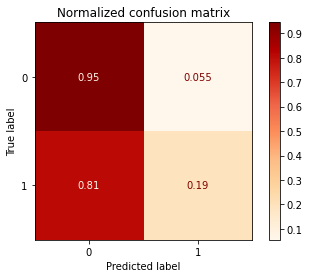


Classification report
              precision    recall  f1-score   support

           0       0.85      0.95      0.89       146
           1       0.43      0.19      0.27        31

    accuracy                           0.81       177
   macro avg       0.64      0.57      0.58       177
weighted avg       0.77      0.81      0.78       177


Metrics

Accuracy 0.8135593220338984
F1-score [0.89320388 0.26666667]
Precision [0.84662577 0.42857143]
Recall [0.94520548 0.19354839]
Roc_auc 0.5693769332744145


Roc curve



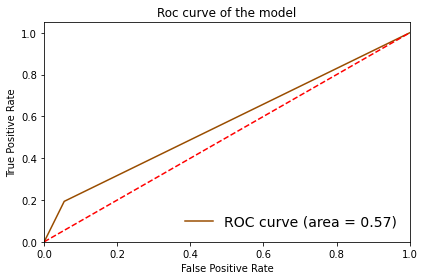


-------------------------------------------------------------------------------------------------------------



In [246]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
max_abs_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MaxAbsScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, max_abs_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = max_abs_dict

In [247]:
scaler_dict

{'MinMaxScaler': {'60-40': {'fpr': [0.0, 0.05802047781569966, 1.0],
   'tpr': [0.0, 0.19672131147540983, 1.0],
   'roc': 0.5693504168298551},
  '70-30': {'fpr': [0.0, 0.1415525114155251, 1.0],
   'tpr': [0.0, 0.30434782608695654, 1.0],
   'roc': 0.5813976573357157},
  '80-20': {'fpr': [0.0, 0.04794520547945205, 1.0],
   'tpr': [0.0, 0.22580645161290322, 1.0],
   'roc': 0.5889306230667256}},
 'MaxAbsScaler': {'60-40': {'fpr': [0.0, 0.010238907849829351, 1.0],
   'tpr': [0.0, 0.18032786885245902, 1.0],
   'roc': 0.5850444805013149},
  '70-30': {'fpr': [0.0, 0.0547945205479452, 1.0],
   'tpr': [0.0, 0.1956521739130435, 1.0],
   'roc': 0.5704288266825491},
  '80-20': {'fpr': [0.0, 0.0547945205479452, 1.0],
   'tpr': [0.0, 0.1935483870967742, 1.0],
   'roc': 0.5693769332744145}}}

<h4>RobustScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6047090872828806
Best parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(p=1)

Best k ('n_neighbors'): 5

Plots of the metrics used by the grid search


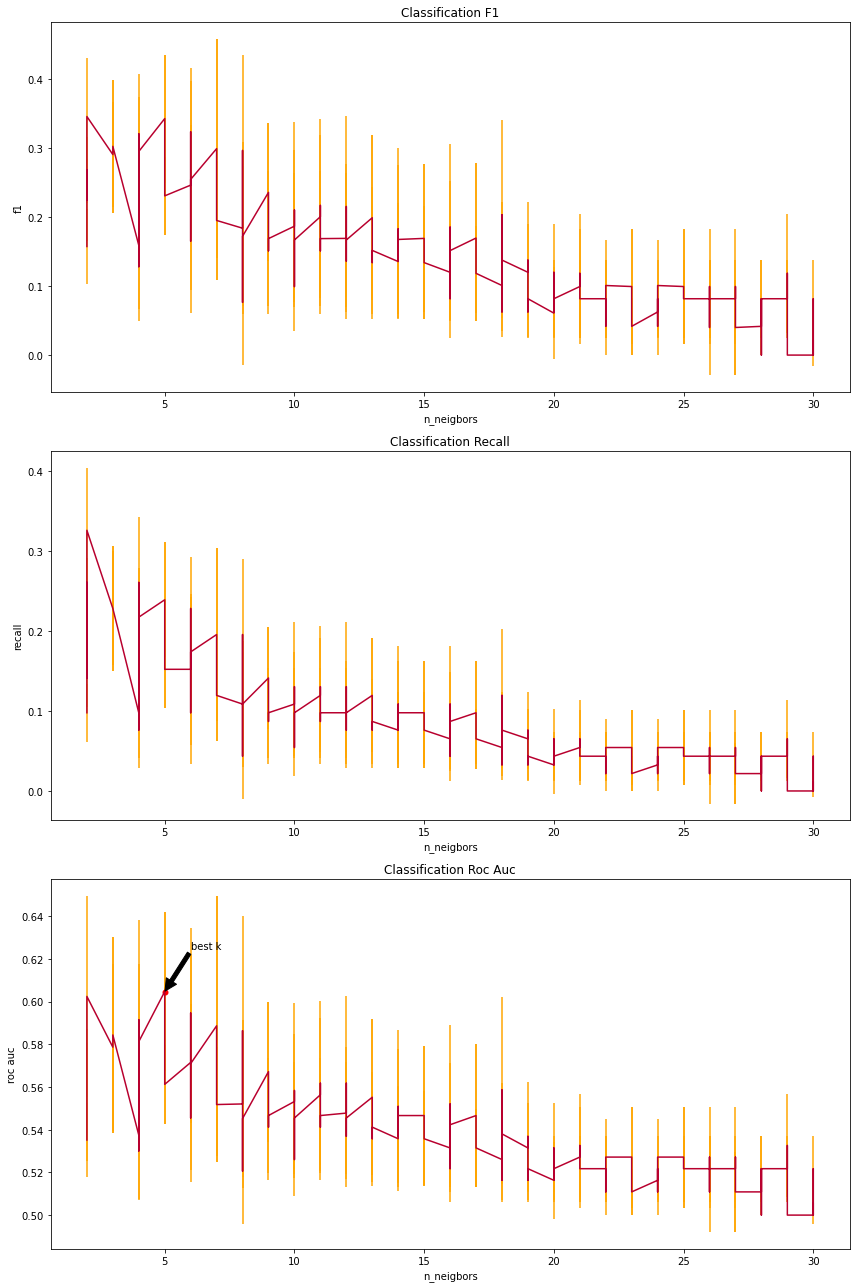



Permutation importances of the training set

StockOptionLevel                                   0.014305
JobLevel                                           0.013279
JobRole_Laboratory_Technician                      0.012614
YearsInCurrentRole                                 0.008096
OverTime                                           0.006248
EnvironmentSatisfaction                            0.004527
OverallSatisfaction                                0.003760
JobSatisfaction                                    0.003384
JobRole_Human_Resources                            0.003129
JobRole_Sales_Representative                       0.002938
JobRole_Research_Scientist                         0.002877
RelationshipSatisfaction                           0.002587
JobRole_Sales_Executive                            0.002429
NumCompaniesWorked                                 0.002337
JobInvolvement                                     0.001796
YearsAtCompany                                     0.

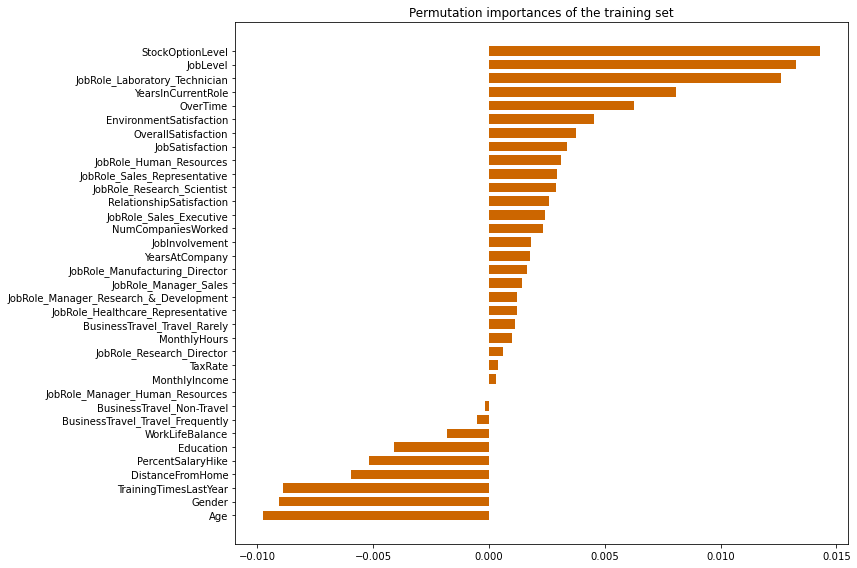



Predictions

Permutation importances of the test set

JobLevel                                           0.028865
StockOptionLevel                                   0.018623
OverTime                                           0.015221
YearsInCurrentRole                                 0.013814
JobRole_Research_Scientist                         0.011761
JobRole_Sales_Representative                       0.005662
BusinessTravel_Travel_Rarely                       0.005575
RelationshipSatisfaction                           0.005044
WorkLifeBalance                                    0.003754
JobRole_Research_Director                          0.003455
JobRole_Manager_Sales                              0.003161
JobRole_Manufacturing_Director                     0.002971
MonthlyIncome                                      0.002711
JobRole_Laboratory_Technician                      0.002361
JobSatisfaction                                    0.001776
JobRole_Healthcare_Representative           

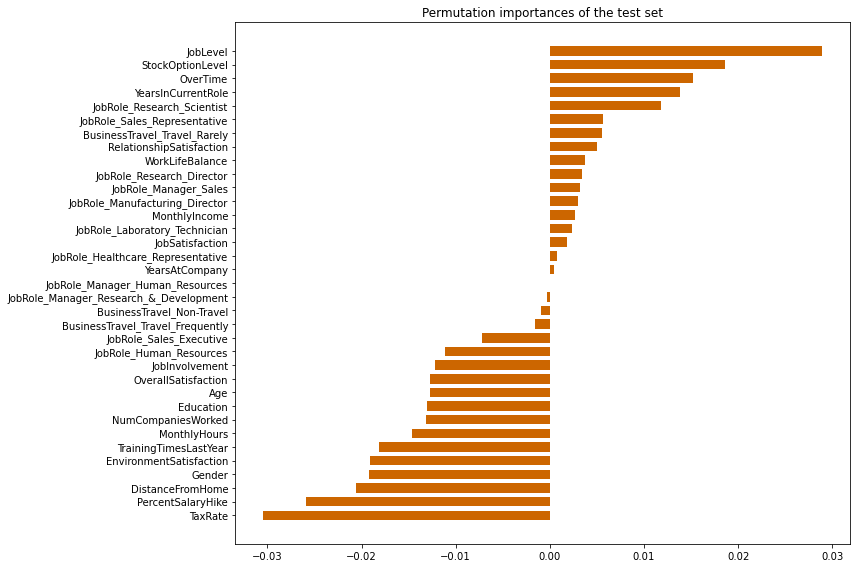



Confusion matrix


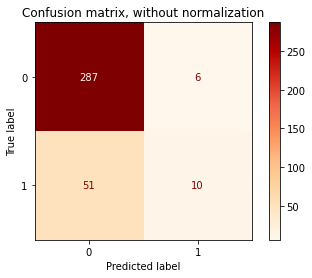

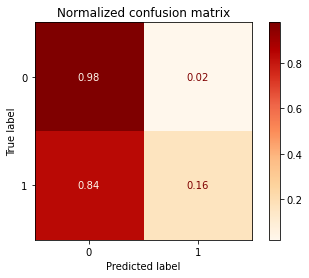


Classification report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       293
           1       0.62      0.16      0.26        61

    accuracy                           0.84       354
   macro avg       0.74      0.57      0.58       354
weighted avg       0.81      0.84      0.80       354


Metrics

Accuracy 0.8389830508474576
F1-score [0.90966719 0.25974026]
Precision [0.84911243 0.625     ]
Recall [0.97952218 0.16393443]
Roc_auc 0.5717283052649248


Roc curve



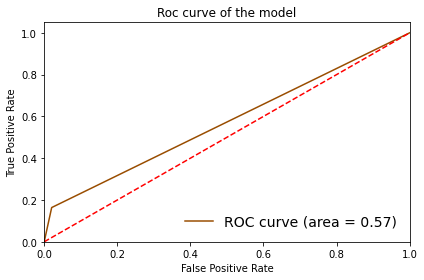


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5965391082424794
Best parameters: {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=6, p=1, weights='distance')

Best k ('n_neighbors'): 6

Plots of the metrics used by the grid search


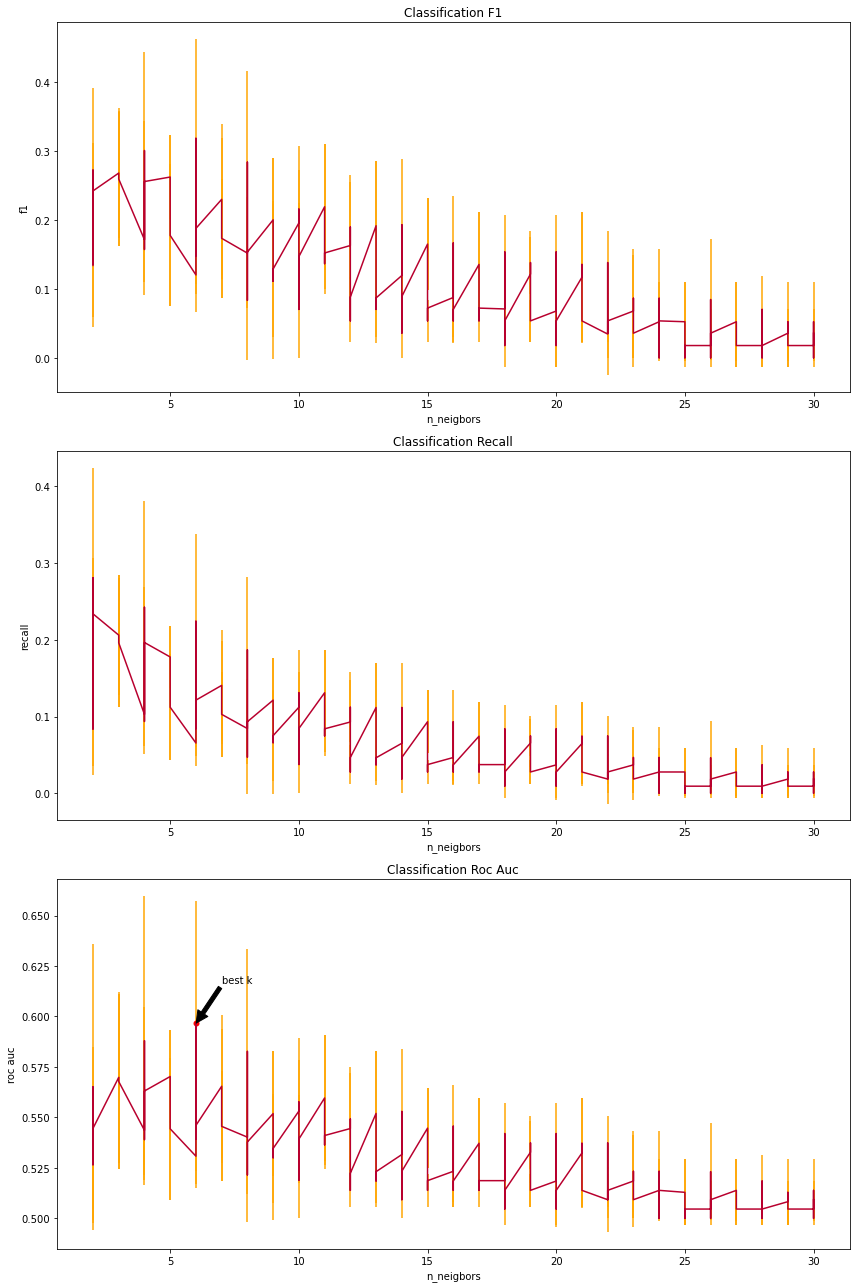



Permutation importances of the training set

TrainingTimesLastYear                              0.000377
StockOptionLevel                                   0.000155
JobLevel                                           0.000027
JobInvolvement                                     0.000015
WorkLifeBalance                                    0.000009
Age                                                0.000000
BusinessTravel_Non-Travel                          0.000000
BusinessTravel_Travel_Frequently                   0.000000
BusinessTravel_Travel_Rarely                       0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobRole_Healthcare_Representative                  0.000000
JobRole_Human_Resources                            0.000000
JobRole_Laboratory_Technician                      0.

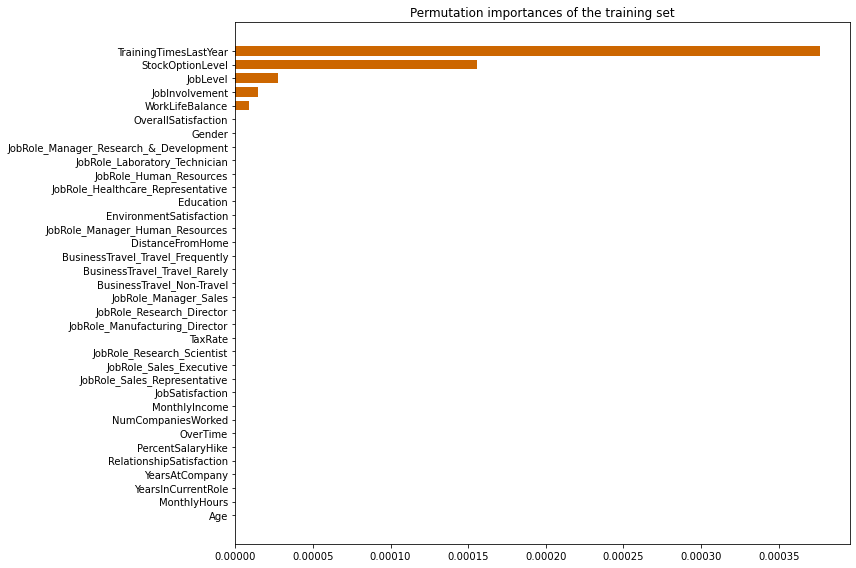



Predictions

Permutation importances of the test set

OverTime                                           0.036048
StockOptionLevel                                   0.033383
JobLevel                                           0.021297
MonthlyIncome                                      0.019664
JobRole_Manufacturing_Director                     0.012359
JobRole_Sales_Representative                       0.010611
JobSatisfaction                                    0.010244
BusinessTravel_Travel_Rarely                       0.009539
BusinessTravel_Travel_Frequently                   0.009356
JobRole_Research_Scientist                         0.003112
WorkLifeBalance                                    0.003023
JobRole_Research_Director                          0.002323
JobRole_Healthcare_Representative                  0.000561
YearsAtCompany                                     0.000447
JobRole_Manager_Human_Resources                    -0.000010
JobRole_Manager_Sales                      

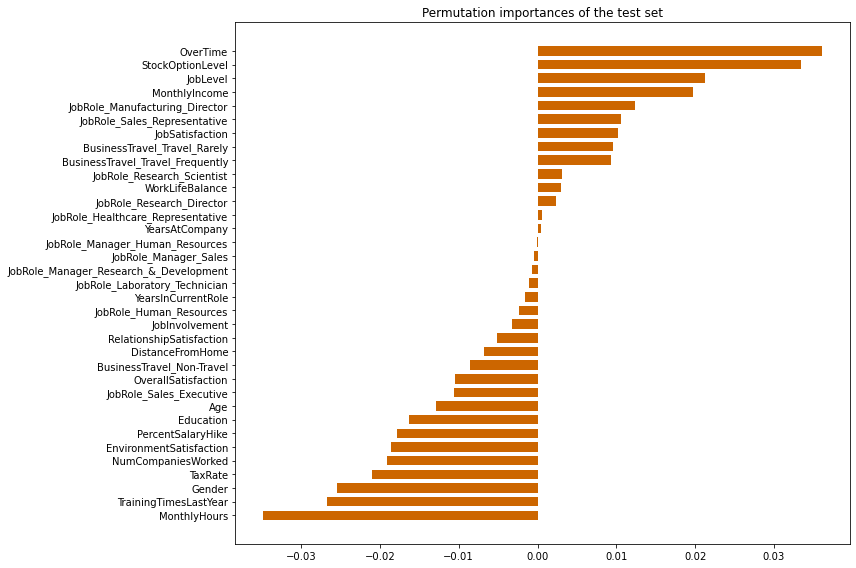



Confusion matrix


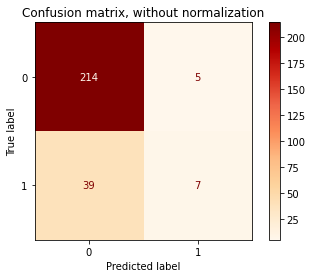

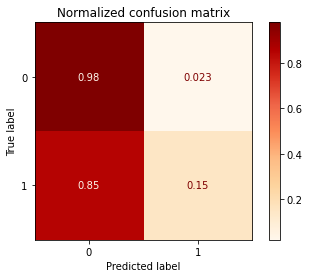


Classification report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       219
           1       0.58      0.15      0.24        46

    accuracy                           0.83       265
   macro avg       0.71      0.56      0.57       265
weighted avg       0.80      0.83      0.79       265


Metrics

Accuracy 0.8339622641509434
F1-score [0.90677966 0.24137931]
Precision [0.8458498  0.58333333]
Recall [0.97716895 0.15217391]
Roc_auc 0.5646714314075839


Roc curve



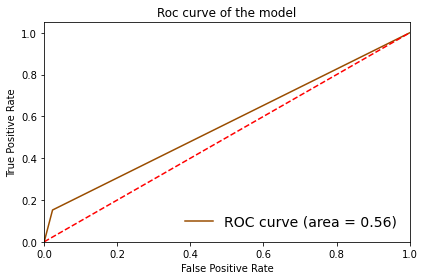


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6134408602150538
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


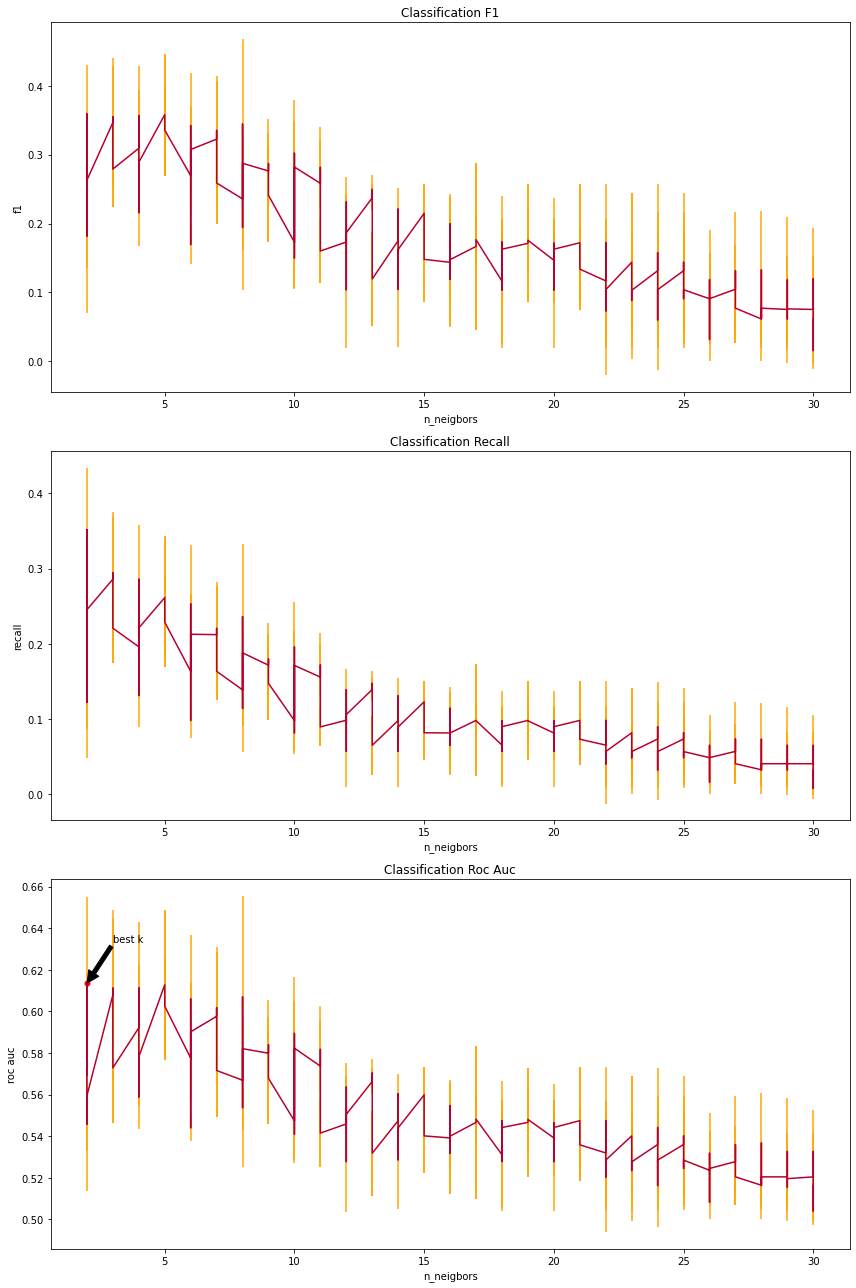



Permutation importances of the training set

PercentSalaryHike                                  0.000000
Age                                                0.000000
JobRole_Research_Scientist                         0.000000
TrainingTimesLastYear                              0.000000
BusinessTravel_Non-Travel                          0.000000
BusinessTravel_Travel_Frequently                   0.000000
BusinessTravel_Travel_Rarely                       0.000000
DistanceFromHome                                   0.000000
Education                                          0.000000
EnvironmentSatisfaction                            0.000000
Gender                                             0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Healthcare_Representative                  0.000000
JobRole_Human_Resources                            0.000000
JobRole_Laboratory_Technician                      0.

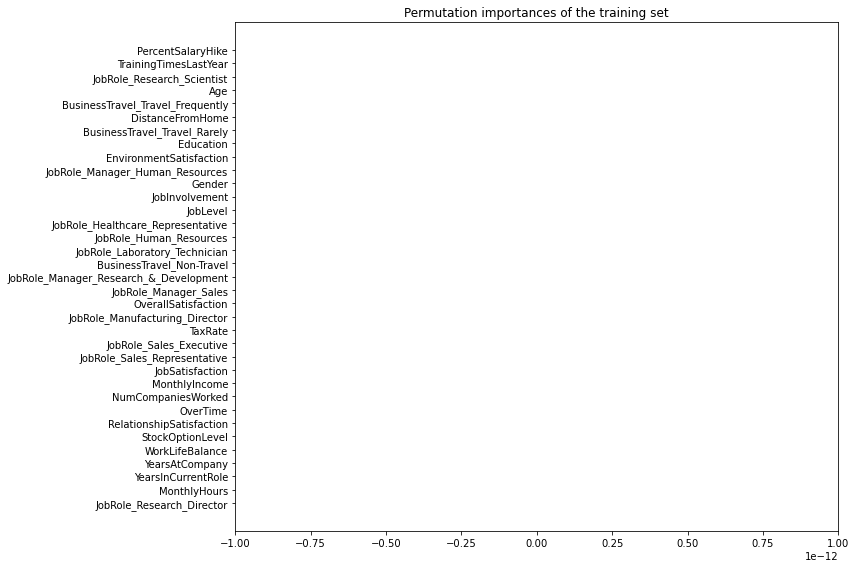



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.063710
JobRole_Research_Scientist                         0.051734
JobInvolvement                                     0.044057
NumCompaniesWorked                                 0.038135
Age                                                0.037229
JobRole_Sales_Executive                            0.024050
JobRole_Sales_Representative                       0.023420
JobSatisfaction                                    0.023243
OverTime                                           0.021465
DistanceFromHome                                   0.020901
PercentSalaryHike                                  0.020592
RelationshipSatisfaction                           0.015996
OverallSatisfaction                                0.014980
TrainingTimesLastYear                              0.010760
MonthlyIncome                                      0.006905
WorkLifeBalance                             

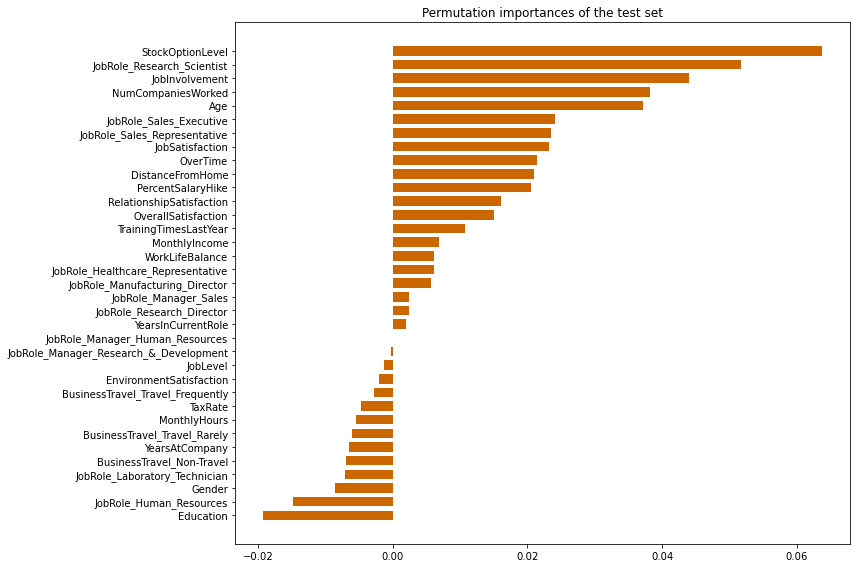



Confusion matrix


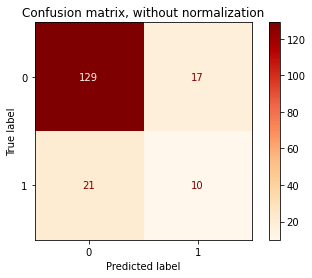

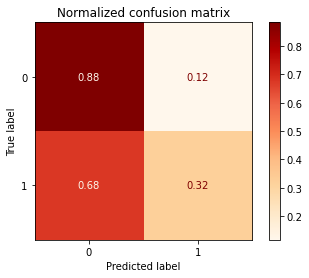


Classification report
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       146
           1       0.37      0.32      0.34        31

    accuracy                           0.79       177
   macro avg       0.62      0.60      0.61       177
weighted avg       0.77      0.79      0.78       177


Metrics

Accuracy 0.7853107344632768
F1-score [0.87162162 0.34482759]
Precision [0.86       0.37037037]
Recall [0.88356164 0.32258065]
Roc_auc 0.6030711444984533


Roc curve



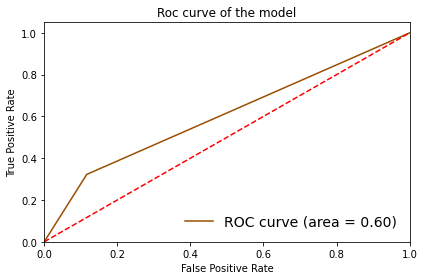


-------------------------------------------------------------------------------------------------------------



In [248]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
robust_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = RobustScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, robust_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = robust_dict

In [249]:
scaler_dict

{'MinMaxScaler': {'60-40': {'fpr': [0.0, 0.05802047781569966, 1.0],
   'tpr': [0.0, 0.19672131147540983, 1.0],
   'roc': 0.5693504168298551},
  '70-30': {'fpr': [0.0, 0.1415525114155251, 1.0],
   'tpr': [0.0, 0.30434782608695654, 1.0],
   'roc': 0.5813976573357157},
  '80-20': {'fpr': [0.0, 0.04794520547945205, 1.0],
   'tpr': [0.0, 0.22580645161290322, 1.0],
   'roc': 0.5889306230667256}},
 'MaxAbsScaler': {'60-40': {'fpr': [0.0, 0.010238907849829351, 1.0],
   'tpr': [0.0, 0.18032786885245902, 1.0],
   'roc': 0.5850444805013149},
  '70-30': {'fpr': [0.0, 0.0547945205479452, 1.0],
   'tpr': [0.0, 0.1956521739130435, 1.0],
   'roc': 0.5704288266825491},
  '80-20': {'fpr': [0.0, 0.0547945205479452, 1.0],
   'tpr': [0.0, 0.1935483870967742, 1.0],
   'roc': 0.5693769332744145}},
 'RobustScaler': {'60-40': {'fpr': [0.0, 0.020477815699658702, 1.0],
   'tpr': [0.0, 0.16393442622950818, 1.0],
   'roc': 0.5717283052649248},
  '70-30': {'fpr': [0.0, 0.0228310502283105, 1.0],
   'tpr': [0.0, 0.15

<h4>StandardScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6175834934909525
Best parameters: {'n_neighbors': 4, 'p': 2, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


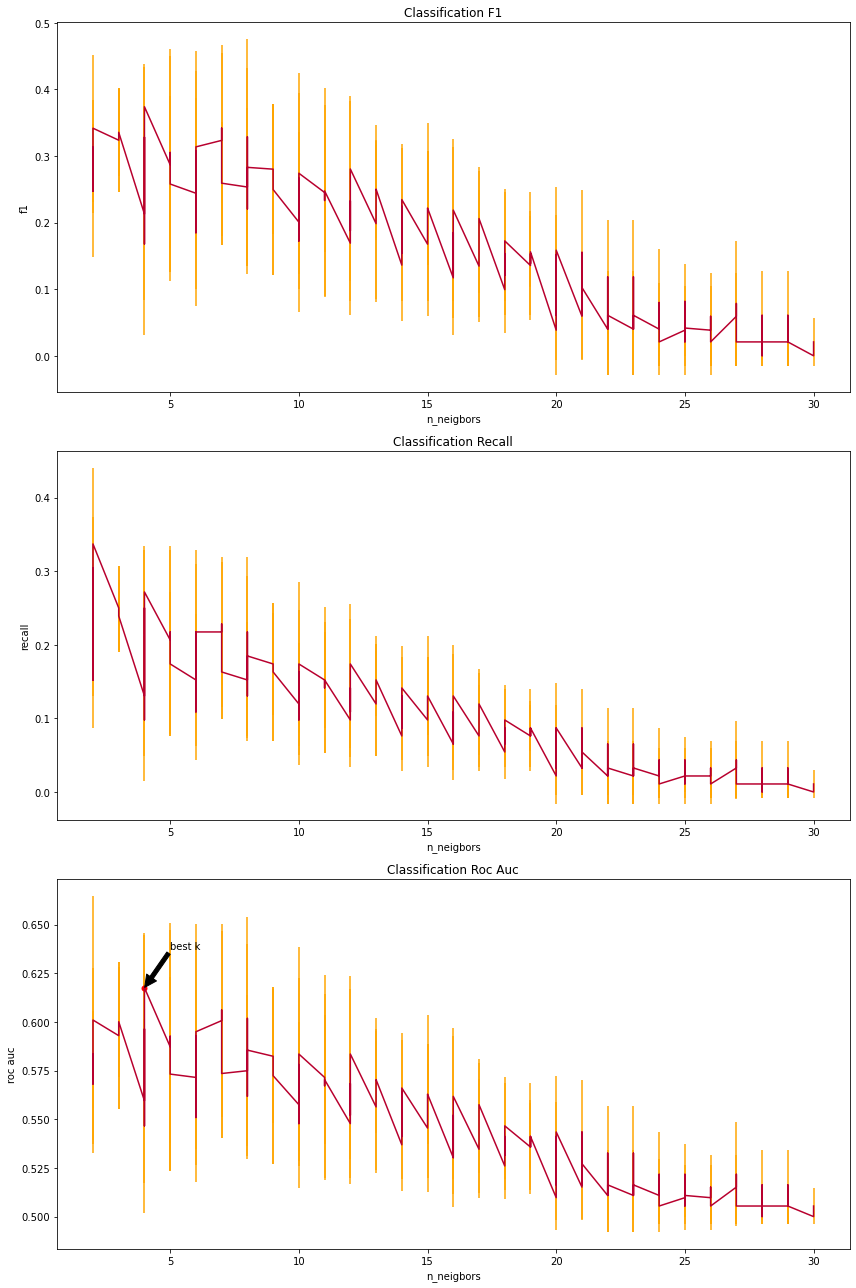



Permutation importances of the training set

OverTime                                           0.002059
StockOptionLevel                                   0.001915
BusinessTravel_Travel_Frequently                   0.001863
BusinessTravel_Non-Travel                          0.001754
JobRole_Laboratory_Technician                      0.001637
RelationshipSatisfaction                           0.001435
JobRole_Sales_Representative                       0.001400
WorkLifeBalance                                    0.001209
JobRole_Sales_Executive                            0.001159
TrainingTimesLastYear                              0.001045
JobInvolvement                                     0.000940
OverallSatisfaction                                0.000779
MonthlyHours                                       0.000766
PercentSalaryHike                                  0.000759
JobRole_Manufacturing_Director                     0.000714
DistanceFromHome                                   0.

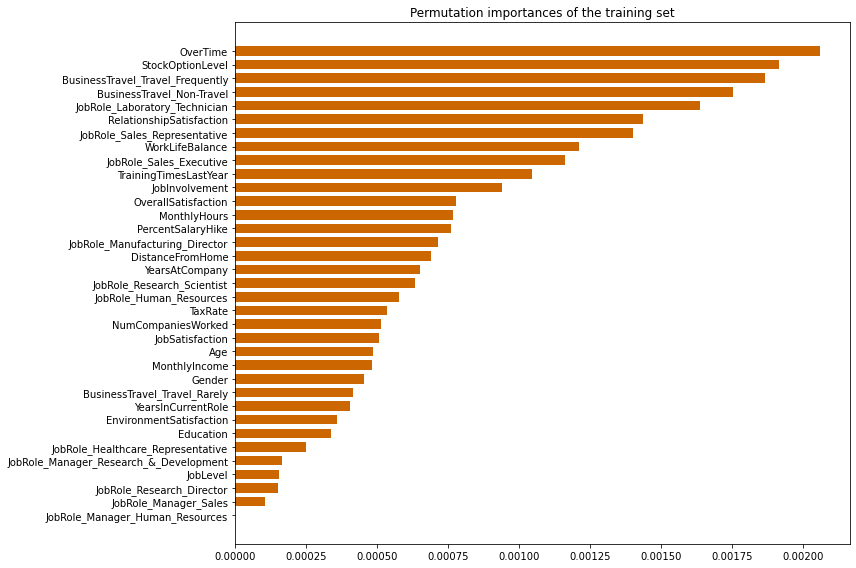



Predictions

Permutation importances of the test set

OverTime                                           0.040715
StockOptionLevel                                   0.035198
BusinessTravel_Travel_Frequently                   0.030140
Age                                                0.027978
RelationshipSatisfaction                           0.026680
JobRole_Laboratory_Technician                      0.026171
JobSatisfaction                                    0.024531
JobRole_Sales_Representative                       0.023980
WorkLifeBalance                                    0.023351
YearsInCurrentRole                                 0.020897
MonthlyHours                                       0.018335
JobInvolvement                                     0.017003
MonthlyIncome                                      0.015935
YearsAtCompany                                     0.015795
BusinessTravel_Travel_Rarely                       0.013739
JobRole_Research_Director                   

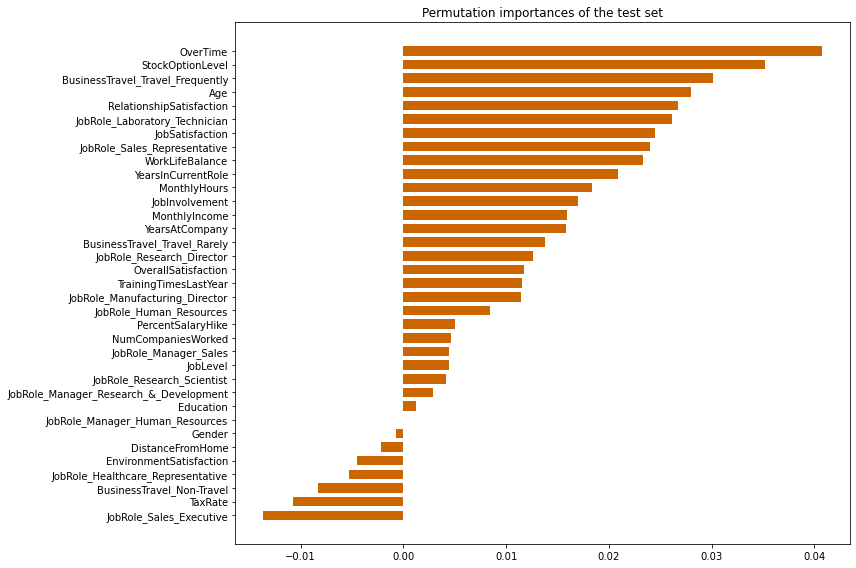



Confusion matrix


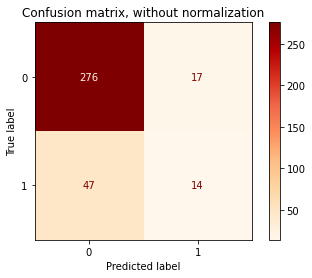

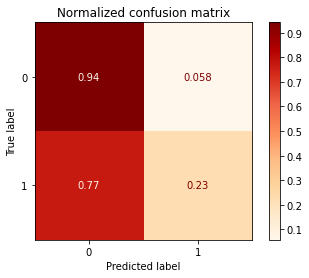


Classification report
              precision    recall  f1-score   support

           0       0.85      0.94      0.90       293
           1       0.45      0.23      0.30        61

    accuracy                           0.82       354
   macro avg       0.65      0.59      0.60       354
weighted avg       0.79      0.82      0.79       354


Metrics

Accuracy 0.8192090395480226
F1-score [0.8961039  0.30434783]
Precision [0.85448916 0.4516129 ]
Recall [0.94197952 0.2295082 ]
Roc_auc 0.5857438594528059


Roc curve



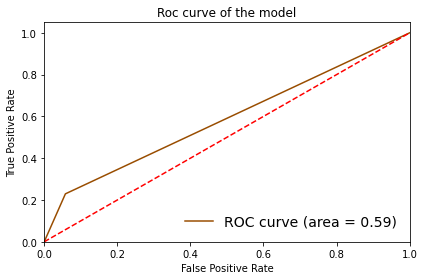


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5925346696446598
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=3, p=1)

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


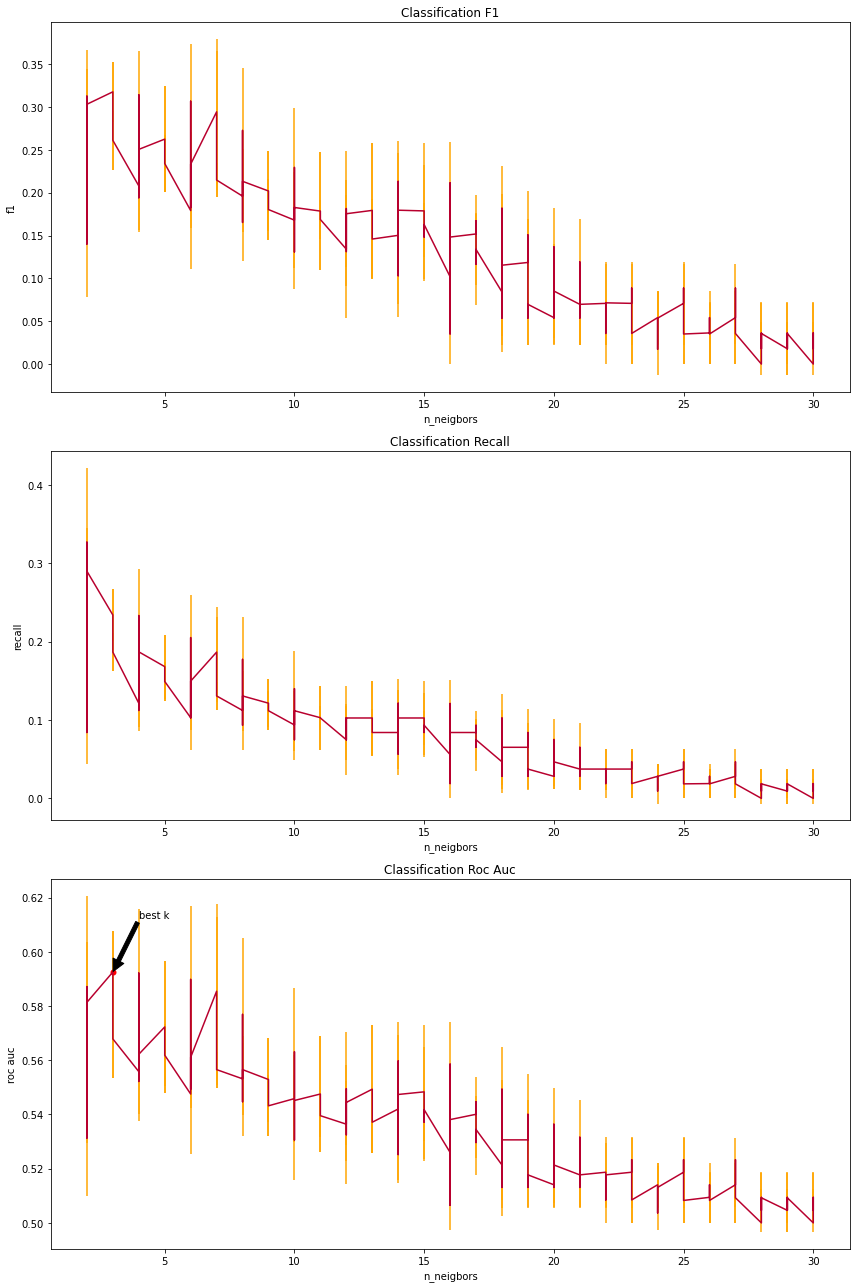



Permutation importances of the training set

OverTime                                           0.006336
JobRole_Sales_Representative                       0.004457
StockOptionLevel                                   0.003688
JobRole_Manufacturing_Director                     0.002757
JobRole_Human_Resources                            0.002503
YearsInCurrentRole                                 0.001872
JobRole_Laboratory_Technician                      0.001126
NumCompaniesWorked                                 0.000903
TrainingTimesLastYear                              0.000716
JobRole_Manager_Human_Resources                    0.000503
EnvironmentSatisfaction                            0.000475
JobRole_Healthcare_Representative                  0.000412
JobRole_Research_Director                          0.000096
PercentSalaryHike                                  -0.000149
WorkLifeBalance                                    -0.000230
JobRole_Manager_Research_&_Development             

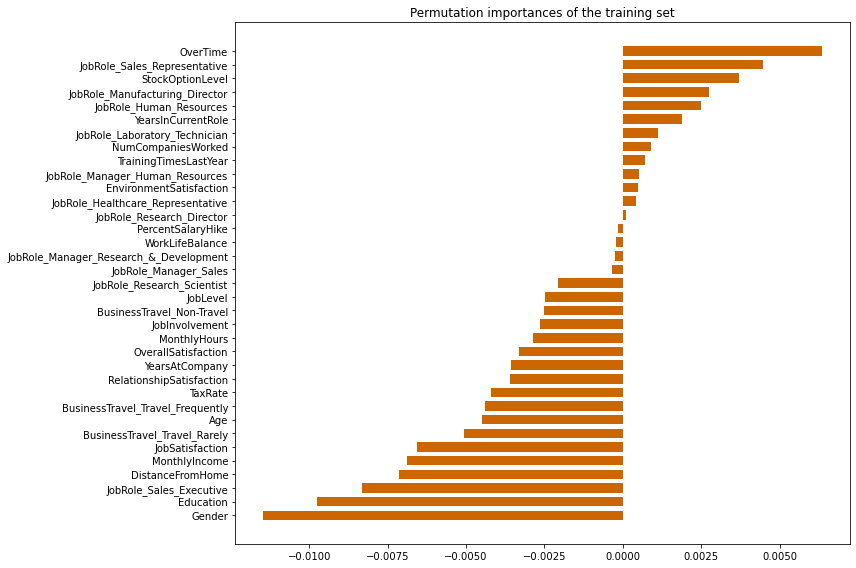



Predictions

Permutation importances of the test set

Age                                                0.031130
MonthlyIncome                                      0.030072
WorkLifeBalance                                    0.025988
YearsInCurrentRole                                 0.025293
BusinessTravel_Travel_Rarely                       0.023531
JobRole_Manufacturing_Director                     0.023357
StockOptionLevel                                   0.022087
BusinessTravel_Travel_Frequently                   0.021466
JobLevel                                           0.018394
JobInvolvement                                     0.018136
OverTime                                           0.017366
JobRole_Human_Resources                            0.014334
JobRole_Healthcare_Representative                  0.010959
JobRole_Research_Scientist                         0.009743
OverallSatisfaction                                0.007668
Education                                   

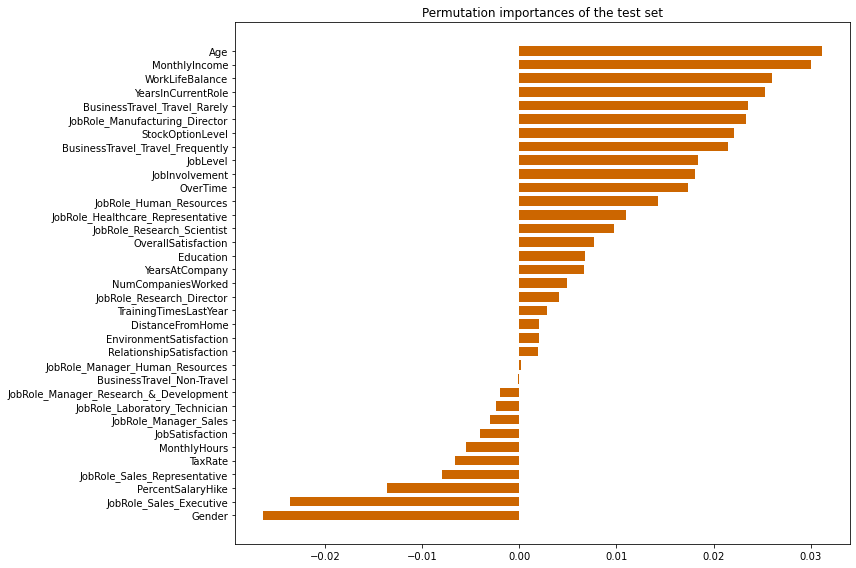



Confusion matrix


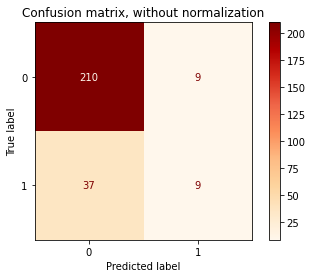

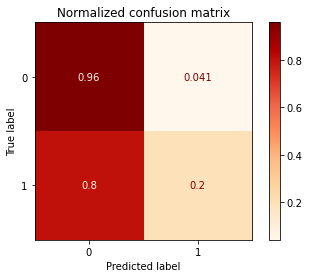


Classification report
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       219
           1       0.50      0.20      0.28        46

    accuracy                           0.83       265
   macro avg       0.68      0.58      0.59       265
weighted avg       0.79      0.83      0.79       265


Metrics

Accuracy 0.8264150943396227
F1-score [0.90128755 0.28125   ]
Precision [0.85020243 0.5       ]
Recall [0.95890411 0.19565217]
Roc_auc 0.5772781417510423


Roc curve



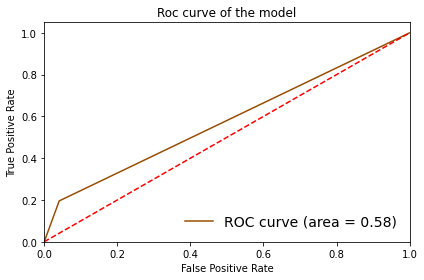


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.624917145382236
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=3, p=1)

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


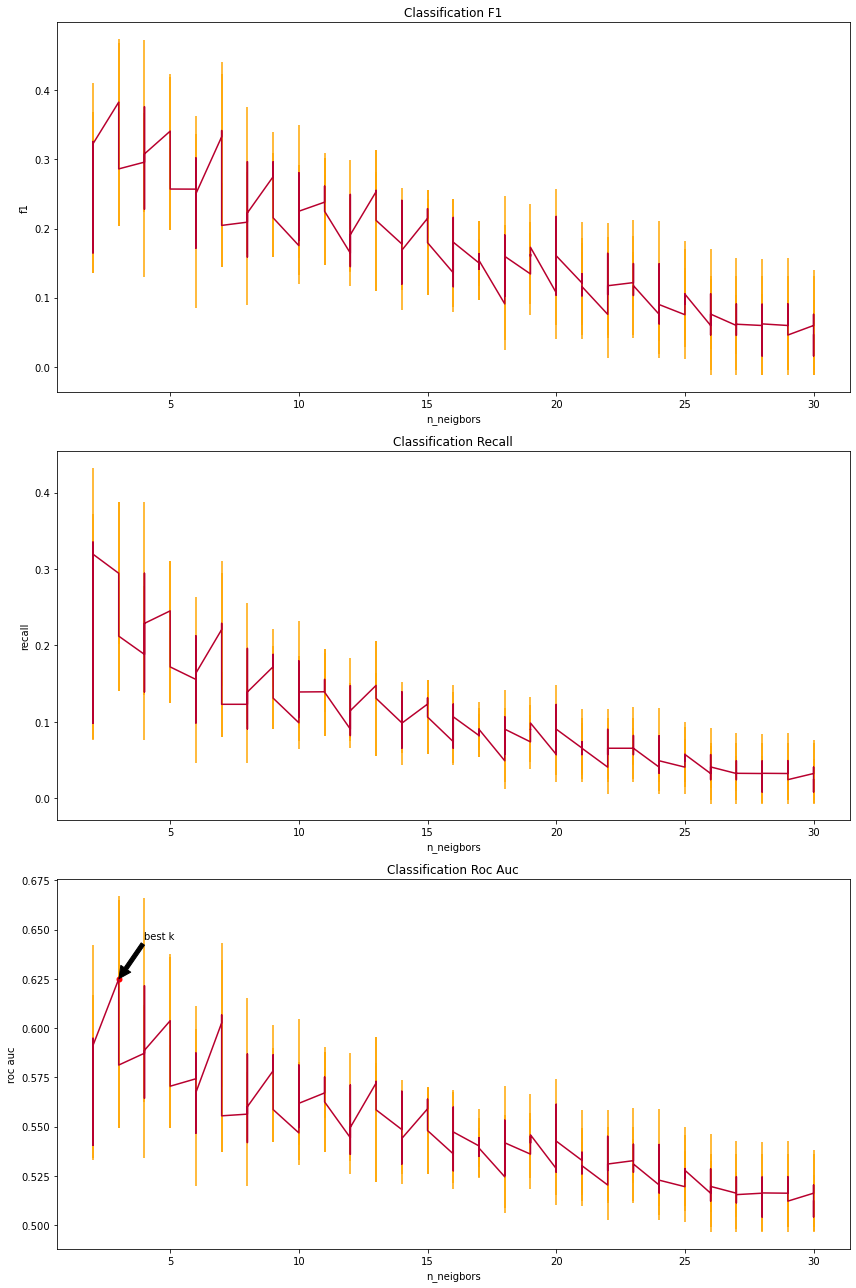



Permutation importances of the training set

OverTime                                           0.008932
EnvironmentSatisfaction                            0.007592
JobRole_Sales_Representative                       0.003453
StockOptionLevel                                   0.002747
JobRole_Manufacturing_Director                     0.001448
JobInvolvement                                     0.001165
JobRole_Human_Resources                            0.001143
OverallSatisfaction                                0.000967
JobRole_Research_Director                          0.000531
JobRole_Manager_Human_Resources                    0.000425
JobLevel                                           0.000359
JobRole_Manager_Sales                              -0.000501
JobRole_Manager_Research_&_Development             -0.000611
WorkLifeBalance                                    -0.000848
YearsAtCompany                                     -0.001039
JobSatisfaction                                  

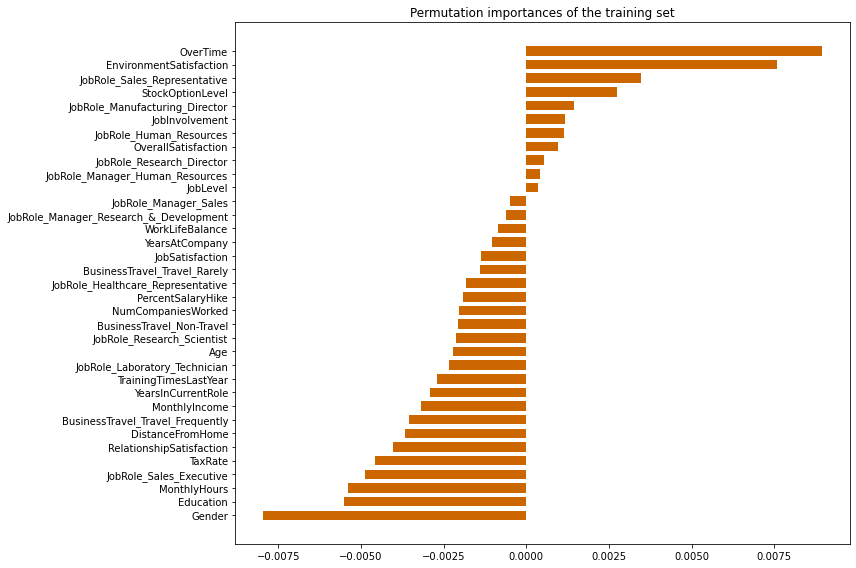



Predictions

Permutation importances of the test set

OverTime                                           0.056894
YearsInCurrentRole                                 0.052176
JobRole_Research_Scientist                         0.040963
WorkLifeBalance                                    0.033053
StockOptionLevel                                   0.032877
RelationshipSatisfaction                           0.029364
JobLevel                                           0.027640
JobSatisfaction                                    0.024437
JobRole_Manufacturing_Director                     0.023067
JobInvolvement                                     0.021178
JobRole_Healthcare_Representative                  0.018681
Age                                                0.017576
JobRole_Human_Resources                            0.014958
PercentSalaryHike                                  0.014605
TaxRate                                            0.011986
DistanceFromHome                            

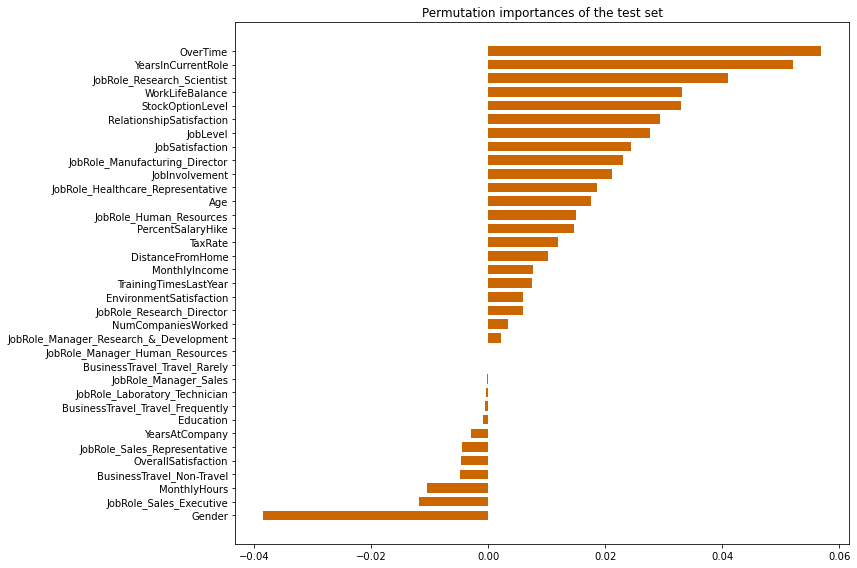



Confusion matrix


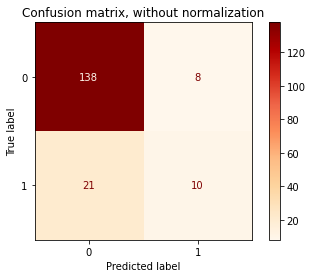

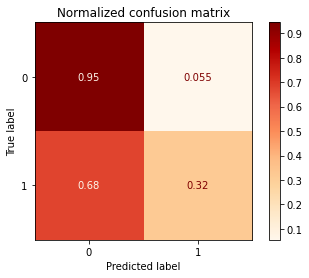


Classification report
              precision    recall  f1-score   support

           0       0.87      0.95      0.90       146
           1       0.56      0.32      0.41        31

    accuracy                           0.84       177
   macro avg       0.71      0.63      0.66       177
weighted avg       0.81      0.84      0.82       177


Metrics

Accuracy 0.8361581920903954
F1-score [0.90491803 0.40816327]
Precision [0.86792453 0.55555556]
Recall [0.94520548 0.32258065]
Roc_auc 0.6338930623066725


Roc curve



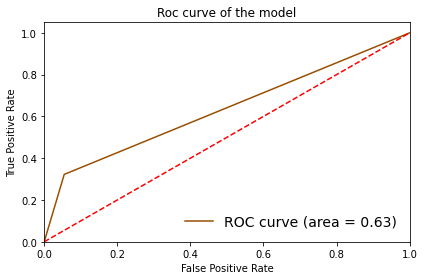


-------------------------------------------------------------------------------------------------------------



In [250]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
standard_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = StandardScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, standard_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = standard_dict

In [251]:
scaler_dict

{'MinMaxScaler': {'60-40': {'fpr': [0.0, 0.05802047781569966, 1.0],
   'tpr': [0.0, 0.19672131147540983, 1.0],
   'roc': 0.5693504168298551},
  '70-30': {'fpr': [0.0, 0.1415525114155251, 1.0],
   'tpr': [0.0, 0.30434782608695654, 1.0],
   'roc': 0.5813976573357157},
  '80-20': {'fpr': [0.0, 0.04794520547945205, 1.0],
   'tpr': [0.0, 0.22580645161290322, 1.0],
   'roc': 0.5889306230667256}},
 'MaxAbsScaler': {'60-40': {'fpr': [0.0, 0.010238907849829351, 1.0],
   'tpr': [0.0, 0.18032786885245902, 1.0],
   'roc': 0.5850444805013149},
  '70-30': {'fpr': [0.0, 0.0547945205479452, 1.0],
   'tpr': [0.0, 0.1956521739130435, 1.0],
   'roc': 0.5704288266825491},
  '80-20': {'fpr': [0.0, 0.0547945205479452, 1.0],
   'tpr': [0.0, 0.1935483870967742, 1.0],
   'roc': 0.5693769332744145}},
 'RobustScaler': {'60-40': {'fpr': [0.0, 0.020477815699658702, 1.0],
   'tpr': [0.0, 0.16393442622950818, 1.0],
   'roc': 0.5717283052649248},
  '70-30': {'fpr': [0.0, 0.0228310502283105, 1.0],
   'tpr': [0.0, 0.15

In [268]:
temporal_info = {}

In [269]:
discretization = 'qcut'
model_name = '36f onehot-encoded quantile discretized'
type_flag = 'validation'

In [270]:
temporal_info[discretization] = {}
temporal_info[discretization][type_flag] = {}
temporal_info[discretization][type_flag][model_name] = scaler_dict['StandardScaler']['80-20']
temporal_info

{'qcut': {'validation': {'36f onehot-encoded quantile discretized': {'fpr': [0.0,
     0.0547945205479452,
     1.0],
    'tpr': [0.0, 0.3225806451612903, 1.0],
    'roc': 0.6338930623066725}}}}

In [271]:
with open('temporal_info.json', 'w') as fp:
    json.dump(temporal_info, fp, indent=4)